# Indoor Localization using IMU and Wi-Fi Data

## Introduction and Problem Statement

This notebook explores various machine learning techniques for indoor localization, a critical task with applications ranging from asset tracking to emergency services. Unlike outdoor environments where GPS is widely available, accurate indoor positioning remains a significant challenge due to signal attenuation, multipath effects, and non-line-of-sight conditions. This study focuses on leveraging two primary data sources: Inertial Measurement Units (IMUs) and Wi-Fi signal strengths (RSSI).

IMUs provide motion-related data such as acceleration and angular velocity, which can be integrated to estimate position (dead reckoning). However, IMU data suffers from drift over time, leading to cumulative errors. Wi-Fi RSSI, on the other hand, offers a complementary source of information by providing a unique 'fingerprint' for different locations within an indoor environment. The combination of these two modalities can provide a more robust and accurate localization solution.

### Objective

The main objective of this study is to develop and compare different regression models to predict the 2D (X, Y) position of a device within an indoor setting. We will investigate the performance of both traditional (Linear Regression, Random Forest, XGBoost) and sequential (LSTM, GRU) models, assess the impact of feature engineering on their accuracy, and identify the most effective approach for indoor localization using the provided sensor data.

# Etape 1 : importer et explorer les données

## Import datas and create dataframe
densify data with labels and metadata

In [128]:
# ============================================================
# SYSTÈME & UTILITAIRES
# ============================================================
import os
import shutil
import io
import zipfile
from pathlib import Path
from math import pi


# ============================================================
# RÉSEAU & MANIPULATION DE DONNÉES
# ============================================================
import requests
import pandas as pd
import numpy as np


# ============================================================
# VISUALISATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns


# ============================================================
# MACHINE LEARNING — SCIKIT-LEARN
# ============================================================
# Préparation des données
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modèles
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


# ============================================================
# GRADIENT BOOSTING
# ============================================================
from xgboost import XGBRegressor


# ============================================================
# DEEP LEARNING — PYTORCH
# ============================================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. Remove the files named `dataset_*.csv`
if os.path.exists("dataset_trimmed_densified.csv"):
    os.remove("dataset_trimmed_densified.csv")
    print("Removed dataset_trimmed_densified.csv")
if os.path.exists("dataset_trimmed.csv"):
    os.remove("dataset_trimmed.csv")
    print("Removed dataset_trimmed.csv")

# 2. Remove the file named `y_targets.csv`
if os.path.exists("y_targets.csv"):
    os.remove("y_targets.csv")
    print("Removed y_targets.csv")

# 3. Remove the file named `X_preprocessed.csv`
if os.path.exists("X_preprocessed.csv"):
    os.remove("X_preprocessed.csv")
    print("Removed X_preprocessed.csv")

# 4. Remove the file named `X_feature_engineered.csv`
if os.path.exists("X_feature_engineered.csv"):
    os.remove("X_feature_engineered.csv")
    print("Removed X_feature_engineered.csv")

# 5. Remove the directory named `csv_from_uncloud` and all its contents.
if os.path.exists("csv_from_uncloud"):
    shutil.rmtree("csv_from_uncloud")
    print("Removed directory csv_from_uncloud")

print("Cleanup complete.")


# --- Constants ---
WINDOW_SIZE = 20 # number of points per sequence
EPOCHS = 100 # max epochs to train sequential models
PATIENCE = 20 # Number of epochs to wait for improvement before stopping
ROLLING_WINDOW_SIZE = 10  # IMU temporal analysis
results = [] # Store results for each models

# --- Data Loading and Preprocessing Functions ---

def download_zip(url: str) -> bytes:
    """Télécharge le ZIP depuis l'URL et renvoie son contenu en bytes."""
    resp = requests.get(url)
    resp.raise_for_status()
    return resp.content

def extract_csv_from_zip(zip_bytes: bytes, output_dir: Path):
    """
    Extrait tous les fichiers .csv du ZIP dans output_dir.
    Retourne la liste des chemins des CSV extraits.
    """
    csv_paths = []
    with zipfile.ZipFile(io.BytesIO(zip_bytes)) as zf:
        csv_names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
        for name in csv_names:
            extracted_path = zf.extract(name, path=output_dir)
            csv_paths.append(Path(extracted_path))
    return csv_paths

def load_csvs_to_dataframes(csv_paths):
    """
    Charge chaque CSV dans un DataFrame pandas.
    Retourne un dict {nom_fichier_sans_ext: DataFrame}.
    """
    dfs = {}
    for path in csv_paths:
        name_no_ext = os.path.splitext(os.path.basename(path))[0]
        dfs[name_no_ext] = pd.read_csv(path)
    return dfs

def infer_device_and_motion(filename: str):
    """
    Déduit 'device' et 'motion' à partir du nom de fichier.
    Fonction robuste même si le nom exact change légèrement.
    """
    name = filename.lower()
    device = "esp32" if "esp32" in name else ("samsung" if "samsung" in name else "unknown")
    if "horizontal" in name:
        motion = "horizontal"
    elif "vertical" in name:
        motion = "vertical"
    elif "square" in name:
        motion = "square"
    elif "combined" in name or "combine" in name:
        motion = "combined"
    else:
        motion = "unknown"
    return device, motion

def add_meta_columns(df: pd.DataFrame, filename: str) -> pd.DataFrame:
    device, motion = infer_device_and_motion(filename)
    df = df.copy()
    df["device"] = device
    df["motion"] = motion
    return df

def densify_spatial_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Densifie spatialement les positions (X, Y) pour toutes les lignes.

    Hypothèses :
    - Les lignes où X et Y sont non NaN sont des "ancres" (points de référence).
    - Entre deux ancres successives, on interpole linéairement X et Y.
    - Avant la première ancre : on copie la 1ère ancre.
    - Après la dernière ancre : on copie la dernière ancre.

    Effets :
    - Crée les colonnes :
        - label_X
        - label_Y
    - Supprime les colonnes originales X et Y (remplacées par label_X / label_Y).
    """

    df = df.copy().reset_index(drop=True)

    # Vérifs de base
    if "X" not in df.columns or "Y" not in df.columns:
        # Pas de colonnes X/Y -> on ne peut pas densifier
        return df

    n = len(df)
    if n == 0:
        return df

    # Colonnes de label densifiées
    df["label_X"] = pd.NA
    df["label_Y"] = pd.NA

    # Ancres : lignes où X et Y ne sont pas NaN
    anchor_mask = df["X"].notna() & df["Y"].notna()
    anchor_idxs = list(df.index[anchor_mask])

    if len(anchor_idxs) == 0:
        # Aucune info de position -> rien à faire
        return df

    if len(anchor_idxs) == 1:
        # Une seule ancre -> tout le monde prend ce label
        i0 = anchor_idxs[0]
        x0 = df.loc[i0, "X"]
        y0 = df.loc[i0, "Y"]
        df["label_X"] = x0
        df["label_Y"] = y0

        # On peut maintenant supprimer X/Y
        df = df.drop(columns=["X", "Y"])
        return df

    # 1) Avant la première ancre : on copie la première
    first = anchor_idxs[0]
    x_first = df.loc[first, "X"]
    y_first = df.loc[first, "Y"]
    df.loc[:first, "label_X"] = x_first
    df.loc[:first, "label_Y"] = y_first

    # 2) Segments entre ancres (interpolation linéaire)
    for i_start, i_end in zip(anchor_idxs[:-1], anchor_idxs[1:]):
        x1 = df.loc[i_start, "X"]
        y1 = df.loc[i_start, "Y"]
        x2 = df.loc[i_end, "X"]
        y2 = df.loc[i_end, "Y"]

        length = i_end - i_start
        if length <= 0:
            continue

        for i in range(i_start, i_end + 1):
            alpha = (i - i_start) / length  # 0 → 1
            xi = x1 + alpha * (x2 - x1)
            yi = y1 + alpha * (y2 - y1)
            df.loc[i, "label_X"] = xi
            df.loc[i, "label_Y"] = yi

    # 3) Après la dernière ancre : on copie la dernière
    last = anchor_idxs[-1]
    x_last = df.loc[last, "X"]
    y_last = df.loc[last, "Y"]
    df.loc[last:, "label_X"] = x_last
    df.loc[last:, "label_Y"] = y_last

    # 4) On supprime X / Y, puisqu'on utilise label_X / label_Y
    df = df.drop(columns=["X", "Y"])

    # Ensure label_X and label_Y are float type
    df["label_X"] = df["label_X"].astype(float)
    df["label_Y"] = df["label_Y"].astype(float)

    return df

def timestamp_to_ms(s: pd.Series) -> pd.Series:
    parts = s.astype(str).str.split(":", expand=True)
    if parts.shape[1] != 4:
        raise ValueError("Timestamp doit être au format HH:MM:SS:xx (ex: 17:24:20:16)")
    hh = pd.to_numeric(parts[0], errors="coerce")
    mm = pd.to_numeric(parts[1], errors="coerce")
    ss = pd.to_numeric(parts[2], errors="coerce")
    xx = pd.to_numeric(parts[3], errors="coerce")
    return ((hh*3600 + mm*60 + ss) * 1000) + (xx * 10)

def build_final_dataset(dfs: dict) -> pd.DataFrame:
    processed = []
    for name, df_item in dfs.items():
        df2 = add_meta_columns(df_item, name)
        df2 = densify_spatial_labels(df2)
        processed.append(df2)
    full = pd.concat(processed, ignore_index=True, sort=True)
    return full

Removed dataset_trimmed_densified.csv
Removed y_targets.csv
Removed X_preprocessed.csv
Removed directory csv_from_uncloud
Cleanup complete.


In [129]:
# 1. Define ZIP_URL and OUTPUT_DIR
ZIP_URL = "https://uncloud.univ-nantes.fr/public.php/dav/files/fkkT27xoRkNRmsr/?accept=zip"
OUTPUT_DIR = Path("csv_from_uncloud")

# 2. Download the ZIP file if not already in path
if not os.path.exists("csv_from_uncloud"):
    OUTPUT_DIR.mkdir(exist_ok=True)
    zip_bytes = download_zip(ZIP_URL)
    print("[+] ZIP downloaded.")

    # 3. Extract the CSV files
    csv_paths = extract_csv_from_zip(zip_bytes, OUTPUT_DIR)
    print(f"[+] {len(csv_paths)} CSV files extracted.")

    # 4. Load the extracted CSVs into a dictionary of DataFrames
    dfs_loaded = load_csvs_to_dataframes(csv_paths)
    print(f"[+] {len(dfs_loaded)} DataFrames loaded.")

    # 5. Build the final df DataFrame
    df = build_final_dataset(dfs_loaded)
    print(f"[+] Initial combined DataFrame shape: {df.shape}")

[+] ZIP downloaded.
[+] 10 CSV files extracted.
[+] 10 DataFrames loaded.
[+] Initial combined DataFrame shape: (10256, 43)


## Visualyze and understand dataset

In [130]:
print("\n===============================")
print("1. SHAPE DU DATASET")
print("===============================")
print(f"Nombre de lignes    : {df.shape[0]}")
print(f"Nombre de colonnes  : {df.shape[1]}")


print("\n===============================")
print("2. INFORMATION GENERALE (df.info)")
print("===============================")
df.info()


print("\n===============================")
print("3. STATISTIQUES DESCRIPTIVES (df.describe)")
print("===============================")

# Statistiques numériques uniquement
print("\n--- Colonnes numériques ---")
print(df.describe())

# Stats sur les colonnes catégorielles
print("\n--- Colonnes catégorielles ---")
print(df.describe(include=["object", "category"]))
n_unique_pairs = df[["label_X", "label_Y"]].drop_duplicates().shape[0]
print("Nombre de positions (X,Y) uniques :", n_unique_pairs)



print("\n===============================")
print("4. VALEURS MANQUANTES PAR COLONNE")
print("===============================")

null_counts = df.isna().sum()
null_percent = (null_counts / len(df)) * 100

null_summary = pd.DataFrame({
    "nb_nulls": null_counts,
    "pourcentage_nulls (%)": null_percent
}).sort_values("nb_nulls", ascending=False)

print(null_summary)



1. SHAPE DU DATASET
Nombre de lignes    : 10256
Nombre de colonnes  : 43

2. INFORMATION GENERALE (df.info)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10256 entries, 0 to 10255
Data columns (total 43 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                                                                                                                         

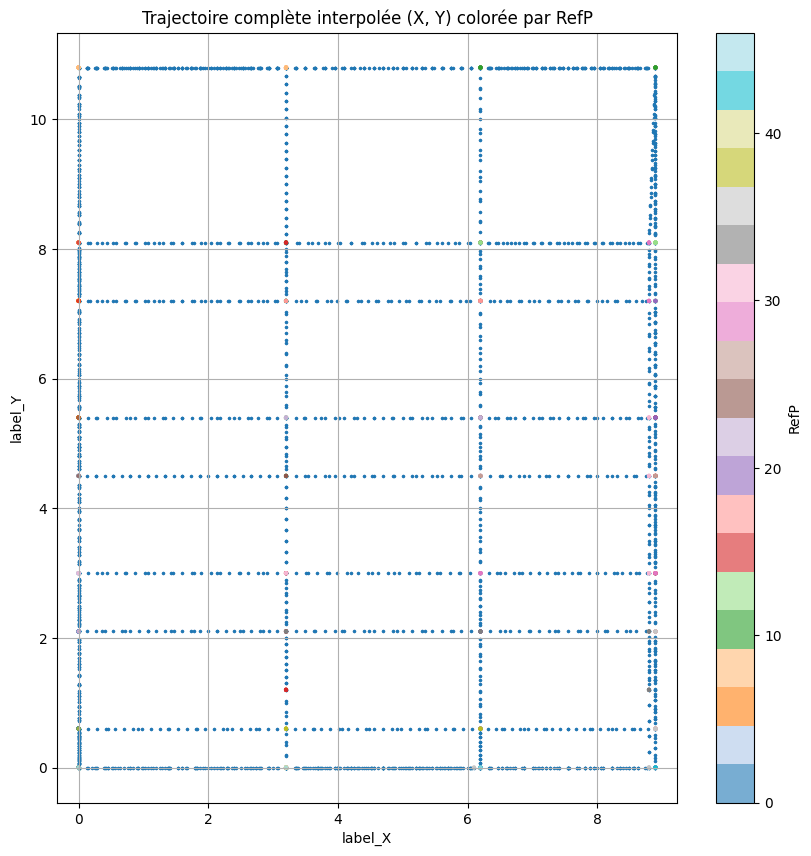

In [131]:
plt.figure(figsize=(10, 10))
plt.title("Trajectoire complète interpolée (X, Y) colorée par RefP")
plt.scatter(df["label_X"], df["label_Y"], s=2, alpha=0.5)
plt.scatter(df["label_X"], df["label_Y"], c=df["RefP"],
            cmap="tab20", s=4, alpha=0.6)
plt.xlabel("label_X")
plt.ylabel("label_Y")
plt.axis("equal")
plt.grid(True)
plt.colorbar(label="RefP")
plt.show(block=False)

## EDA

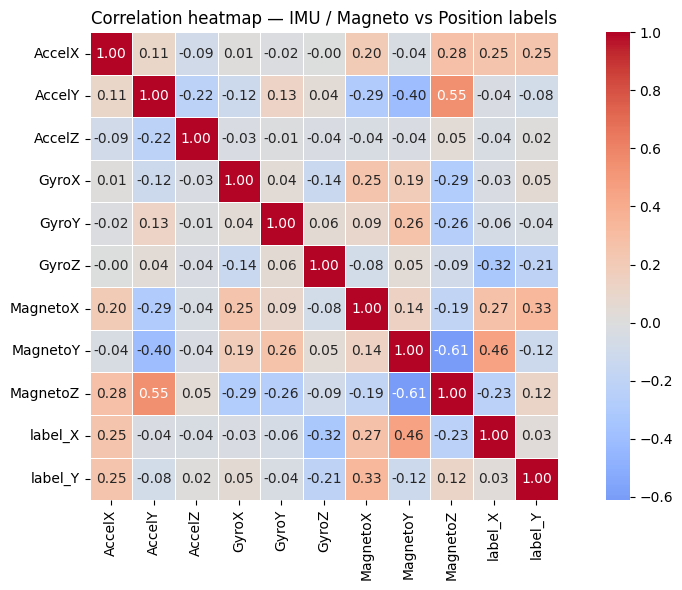

In [132]:
imu_cols = [
    "AccelX", "AccelY", "AccelZ",
    "GyroX", "GyroY", "GyroZ",
    "MagnetoX", "MagnetoY", "MagnetoZ"
]

target_cols = ["label_X", "label_Y"]

corr_cols = imu_cols + target_cols
corr_df = df[corr_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Correlation heatmap — IMU / Magneto vs Position labels")
plt.tight_layout()
plt.show(block=False)


correlation forte entre magnetoY et labelX

Nombre de colonnes Wi-Fi : 21
                                AP  presence_ratio   variance
16       eduroam_c8:b5:ad:f3:73:20        0.753120  53.461909
7        eduroam_84:d4:7e:5f:70:60        0.940718  52.677648
10       eduroam_c8:b5:ad:f3:69:c0        0.948128  25.148430
13       eduroam_c8:b5:ad:f3:6b:60        0.803822  19.006677
20       eduroam_f0:5c:19:c3:5d:a0        0.681747  14.899050
17       eduroam_cc:88:c7:03:a4:a0        0.509360  12.902475
19       eduroam_cc:d0:83:a0:e0:a0        0.709048   7.091800
9        eduroam_b4:5d:50:24:17:40        0.007020   4.056338
3   TP-Link_2FA8_9c:53:22:90:2f:a7        0.282761   3.989801
2            Elb_c6:0a:1e:ab:af:c1        0.171217   2.787127


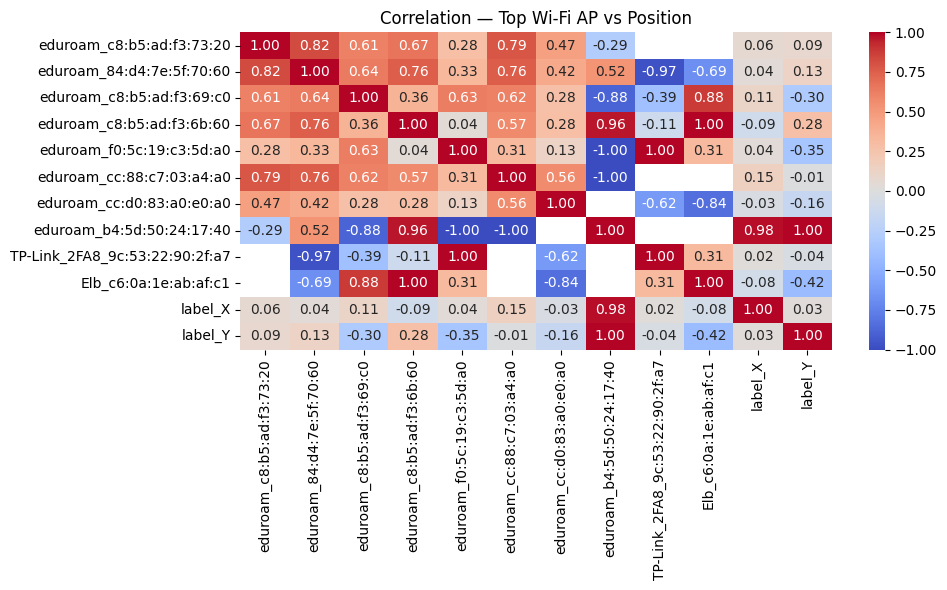

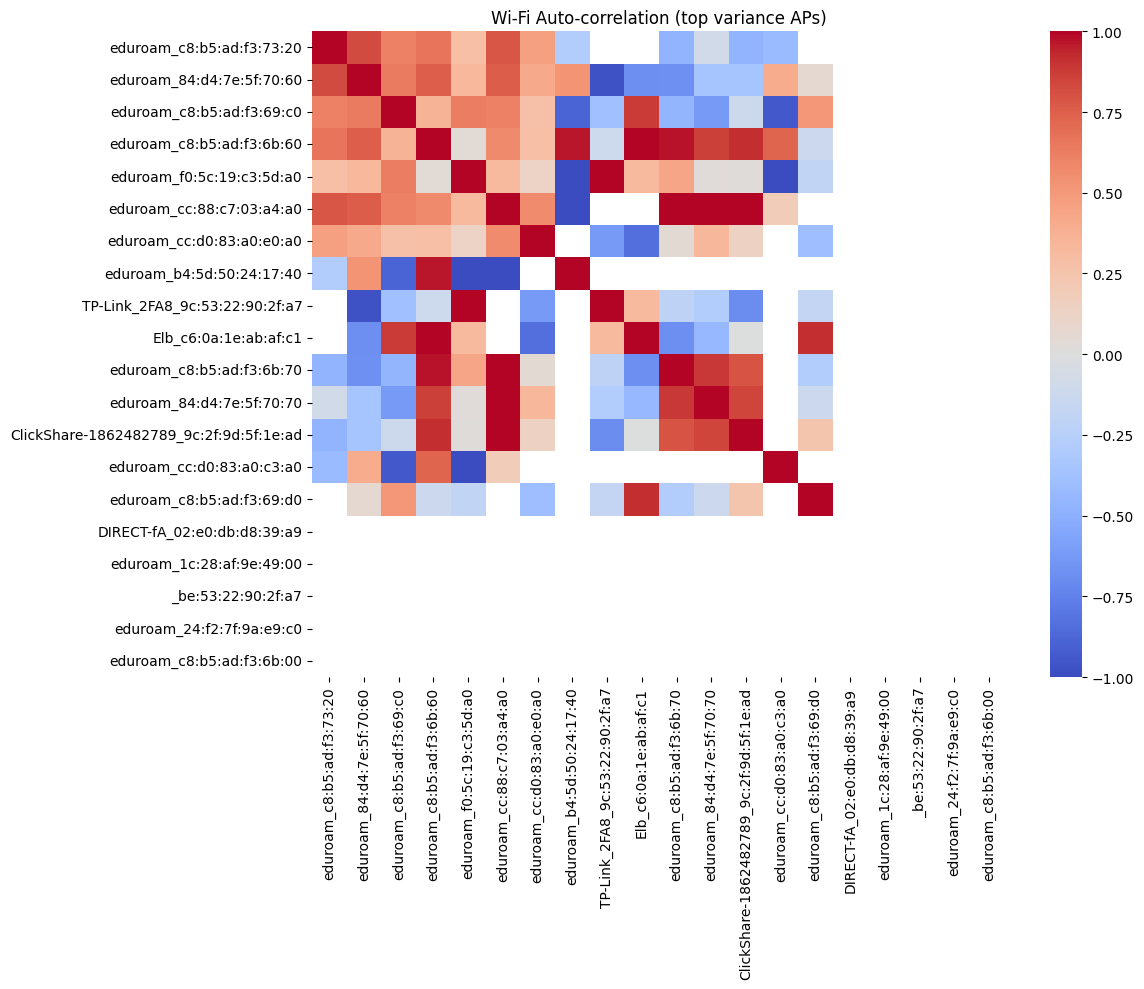

In [133]:
wifi_cols = [c for c in df.columns if any(
    c.lower().startswith(p) for p in [
        "eduroam", "tp-link", "clickshare", "telephone",
        "elb", "direct", "_be"
    ]
)]

print("Nombre de colonnes Wi-Fi :", len(wifi_cols))

wifi_stats = []

for col in wifi_cols:
    present_ratio = df[col].notna().mean()
    variance = df[col].var(skipna=True)
    wifi_stats.append((col, present_ratio, variance))

wifi_stats_df = pd.DataFrame(
    wifi_stats,
    columns=["AP", "presence_ratio", "variance"]
).sort_values("variance", ascending=False)

print(wifi_stats_df.head(10))

top_wifi = wifi_stats_df.head(10)["AP"].tolist()

wifi_corr_cols = top_wifi + ["label_X", "label_Y"]
wifi_corr = df[wifi_corr_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    wifi_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation — Top Wi-Fi AP vs Position")
plt.tight_layout()
plt.show(block=False)

wifi_subset = wifi_stats_df.head(20)["AP"].tolist()
wifi_auto_corr = df[wifi_subset].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    wifi_auto_corr,
    cmap="coolwarm",
    center=0
)
plt.title("Wi-Fi Auto-correlation (top variance APs)")
plt.tight_layout()
plt.show(block=False)


Très bonne méthode d'utiliser les réseaux Wi-Fi pour déterminer les positions

## Pre processing

In [134]:
print("Shape initiale :", df.shape)

# 0) On calcule le taux de nulls AVANT de filtrer les lignes
null_ratio_global = df.isna().mean()

cols_to_keep = null_ratio_global[null_ratio_global <= 0.56].index.tolist()
cols_to_keep.append('RefP')
df_trimmed_1 = df[cols_to_keep]
print("Après suppression colonnes >56% NaN :", df_trimmed_1.shape)

# 1) On enlève maintenant les lignes sans label
df_trimmed = df_trimmed_1.dropna(subset=["label_X", "label_Y"])
print("Après suppression lignes sans label :", df_trimmed.shape)

# 2) Cibles = (X,Y) linear
y = df_trimmed[["label_X", "label_Y"]]
meta = df_trimmed[["device", "label_X", "label_Y"]].reset_index(drop=True)

# 3) on uniformise le vecteur temps pour plus tard
df_trimmed["t_ms"] = timestamp_to_ms(df_trimmed["Timestamp"])

# 3) on enlève tout ce qui est non utile
cols_to_drop = [
    "Index", # doesn't give any informations
    "Timestamp", # new t_ms better
    "vX", "Orientation", "vY" # Always 0.0
]

df_trimmed = df_trimmed.drop(columns=[c for c in cols_to_drop if c in df_trimmed.columns])

# 3.5) Petit fix pour MagnetoX MagnetoY et MagnetoZ
# Impute missing MagnetoX, MagnetoY, MagnetoZ with their median instead of 0.0
for c in ["MagnetoX", "MagnetoY", "MagnetoZ"]:
    if c in df_trimmed.columns:
        if df_trimmed[c].isnull().any():
            df_trimmed[c] = df_trimmed[c].fillna(df_trimmed[c].median())


# 4) on retire les labels des features
cols_to_forget = [
    "label_X", "label_Y", "RefP", # leakage
]

X = df_trimmed.drop(columns=[c for c in cols_to_forget if c in df_trimmed.columns])

print("X shape :", X.shape)
print("y shape :", y.shape)

# 5) Encodage des variables catégorielles et numériques
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]
print("Colonnes catégorielles :", cat_cols)
print("Colonnes numériques :", num_cols)

# 6) Imputation robuste: apply fillna only to numeric columns
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

# 7) Sauvegarde
df_trimmed.to_csv("dataset_trimmed_densified.csv", index=False)

pd.DataFrame(X, columns=X.columns).to_csv(
    "X_preprocessed.csv", index=False
)
y.to_csv("y_targets.csv", index=False)

print("\n[+] Fichiers sauvegardés :")
print(" - dataset_trimmed_densified.csv")
print(" - X_preprocessed.csv")
print(" - y_targets.csv")

Shape initiale : (10256, 43)
Après suppression colonnes >56% NaN : (10256, 30)
Après suppression lignes sans label : (10156, 30)
X shape : (10156, 23)
y shape : (10156, 2)
Colonnes catégorielles : ['device', 'motion']
Colonnes numériques : ['AccelX', 'AccelY', 'AccelZ', 'ClickShare-1862482789_9c:2f:9d:5f:1e:ad', 'GyroX', 'GyroY', 'GyroZ', 'MagnetoX', 'MagnetoY', 'MagnetoZ', 'eduroam_84:d4:7e:5f:70:60', 'eduroam_84:d4:7e:5f:70:70', 'eduroam_c8:b5:ad:f3:69:c0', 'eduroam_c8:b5:ad:f3:69:d0', 'eduroam_c8:b5:ad:f3:6b:60', 'eduroam_c8:b5:ad:f3:6b:70', 'eduroam_c8:b5:ad:f3:73:20', 'eduroam_cc:88:c7:03:a4:a0', 'eduroam_cc:d0:83:a0:e0:a0', 'eduroam_f0:5c:19:c3:5d:a0', 't_ms']


C:\Users\flavi\AppData\Local\Temp\ipykernel_20888\744251335.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed["t_ms"] = timestamp_to_ms(df_trimmed["Timestamp"])



[+] Fichiers sauvegardés :
 - dataset_trimmed_densified.csv
 - X_preprocessed.csv
 - y_targets.csv


## Regression linéaire

### Baseline (Linear Regression)

In [135]:
X_train, X_test, y_train, y_test_raw, meta_train, meta_test = train_test_split(
    X, y, meta, test_size=0.3, random_state=42
)

# Ensure X_train and X_test are DataFrames with column names
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols),
    ]
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test_raw.shape)

# Baseline : Linear Regression
linreg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
y_pred_lr = linreg.predict(X_test)


Train : (7109, 23) (7109, 2)
Test  : (3047, 23) (3047, 2)


=== Linear Regression ===
Erreur moyenne (m) : 3.301082204846627
Erreur médiane (m) : 3.126743931215333
90e percentile (m) : 5.384640034720598


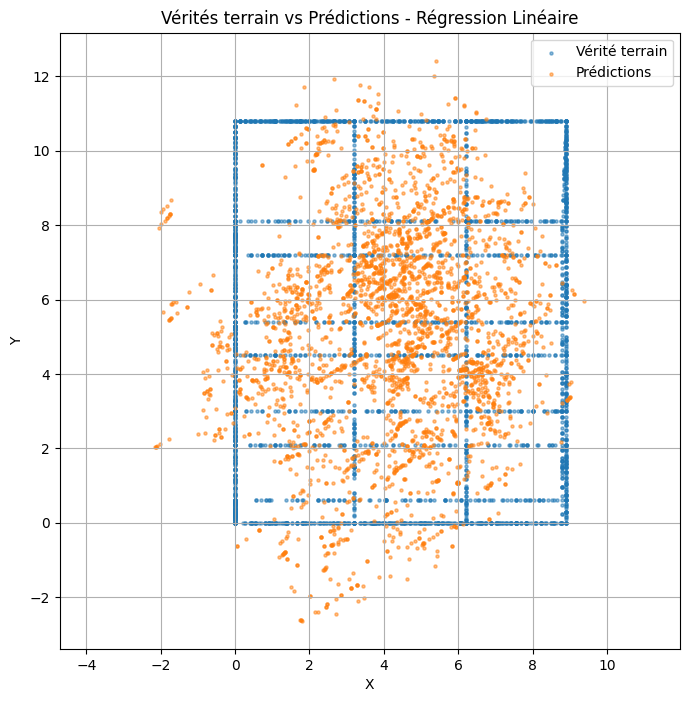

In [136]:
# Analyse des résultats de la baseline
print("=== Linear Regression ===")
errors = np.linalg.norm(y_test_raw.values - y_pred_lr, axis=1)

print("Erreur moyenne (m) :", errors.mean())
print("Erreur médiane (m) :", np.median(errors))
print("90e percentile (m) :", np.percentile(errors, 90))

plt.figure(figsize=(8, 8))
plt.scatter(y_test_raw["label_X"], y_test_raw["label_Y"],
            s=5, alpha=0.5, label="Vérité terrain")
plt.scatter(y_pred_lr[:,0], y_pred_lr[:,1],
            s=5, alpha=0.5, label="Prédictions")

plt.legend()
plt.title("Vérités terrain vs Prédictions - Régression Linéaire")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True)
plt.show(block=False)

Grâce à ce premier test, nous savons que le problème n'est pas linéaire et que les données brutes ne seront pas suffisantes pour ce genre d'analyse.

# Etape 2 : Raffiner les données et entrainer  des modèles de regression tabulaire et séquentiels

## Feature Engineering

In [137]:
# --- Evaluation Metrics Functions ---

def evaluate_regression(y_true, y_pred, name="model"):
    """
    Métriques utiles pour localisation 2D.
    y_true, y_pred : arrays shape (N, 2) avec (X, Y)

    Retourne un dict prêt à logger / mettre en DataFrame.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    if y_true.shape != y_pred.shape or y_true.ndim != 2 or y_true.shape[1] != 2:
        raise ValueError(f"y_true et y_pred doivent être (N,2). Got {y_true.shape=} {y_pred.shape=}")

    # erreurs par axe
    ex = y_pred[:, 0] - y_true[:, 0]
    ey = y_pred[:, 1] - y_true[:, 1]

    # erreur radiale (distance euclidienne)
    err = np.sqrt(ex**2 + ey**2)

    # RMSE par axe + global 2D
    rmse_x = np.sqrt(np.mean(ex**2))
    rmse_y = np.sqrt(np.mean(ey**2))
    rmse_2d = np.sqrt(np.mean(err**2))          # = sqrt(mean(ex^2+ey^2))

    # MAE par axe + radial
    mae_x = np.mean(np.abs(ex))
    mae_y = np.mean(np.abs(ey))
    mae_2d = np.mean(err)

    # biais (erreur moyenne signée) par axe
    bias_x = np.mean(ex)
    bias_y = np.mean(ey)

    # "R95" : rayon contenant 95% des erreurs (super parlant en indoor)
    # (souvent reporté comme CEP95/R95)
    r50 = np.percentile(err, 50)
    r68 = np.percentile(err, 68)               # ~1-sigma si gaussien
    r90 = np.percentile(err, 90)
    r95 = np.percentile(err, 95)
    r99 = np.percentile(err, 99)

    # scores de couverture : P(error < seuil)
    thresholds = [0.25, 0.5, 1.0, 2.0]          # à ajuster selon le cahier des charges
    cov = {f"p_err_lt_{t}m": float(np.mean(err <= t)) for t in thresholds}

    # erreur max + n (utile pour voir les outliers)
    max_err = float(np.max(err))
    n = int(err.shape[0])

    out = {
        "model": name,
        "n": n,

        # global
        "rmse_2d_m": float(rmse_2d),
        "mae_2d_m": float(mae_2d),
        "median_err_m": float(r50),
        "errors_radial_m": err,

        # percentiles / fiabilité
        "p68_err_m": float(r68),
        "p90_err_m": float(r90),
        "p95_err_m": float(r95),
        "p99_err_m": float(r99),
        "max_err_m": max_err,

        # par axe (diagnostic)
        "rmse_x_m": float(rmse_x),
        "rmse_y_m": float(rmse_y),
        "mae_x_m": float(mae_x),
        "mae_y_m": float(mae_y),
        "bias_x_m": float(bias_x),
        "bias_y_m": float(bias_y),
    }

    out.update(cov)
    return out

def feature_engineering_best(
    df_in: pd.DataFrame,
    *,
    # IMU
    imu_cols=("AccelX","AccelY","AccelZ","GyroX","GyroY","GyroZ","MagnetoX","MagnetoY","MagnetoZ"),
    time_col="t_ms",

    # Rolling features
    add_rolling=True,                                   # calcule et ajoute les features *_roll_*
    rolling_window_size=ROLLING_WINDOW_SIZE,            # ROLLING_WINDOW_SIZE
    rolling_group_cols=("device","motion"),
    rolling_imu_cols=("AccelX","AccelY","AccelZ","GyroX","GyroY","GyroZ"),
    rolling_stats=("mean","var","min","max"),

    # Diff/derivatives
    add_diff=True,
    add_dt_derivative=True,
    eps_dt_ms=1.0,

    # Wi-Fi
    wifi_prefixes=("eduroam","tp-link", "clickshare", "telephone","elb","direct","_be"),
    rssi_missing=-100.0,
    wifi_min_presence=0.05,
    wifi_topk=10,

    # NaN handling
    fill_numeric_with="median",        # "median" ou "zero"
    verbose=True
):
    """
    Retourne:
      df_fe: dataframe enrichi (copie)
      X_fe: features finales
      y: labels (label_X,label_Y) si présents sinon None
      meta: dict utile (cols Wi-Fi retenues, stats NaN, etc.)
      feature_cols: liste finale des features (ordre)
    """

    df = df_in.copy()

    # ---------- 0) Sanity checks ----------
    if time_col not in df.columns:
        raise ValueError(f"Il manque la colonne temps '{time_col}'. Génère-la avant (Timestamp -> t_ms).")

    # garde uniquement IMU présentes
    imu_cols = [c for c in imu_cols if c in df.columns]
    if len(imu_cols) == 0:
        raise ValueError("Aucune colonne IMU trouvée (Accel/Gyro/Magneto). Vérifie les noms de colonnes.")

    # ---------- Helpers ----------
    def _fill_series(s: pd.Series) -> pd.Series:
        if not s.isna().any():
            return s
        if fill_numeric_with == "median":
            med = s.median()
            if pd.isna(med):  # colonne entièrement NaN -> fallback 0
                print("Erreur de méthode !")
                med = 0.0
            return s.fillna(med)
        elif fill_numeric_with == "zero":
            return s.fillna(0.0)
        else:
            raise ValueError("fill_numeric_with doit être 'median' ou 'zero'")

    # ---------- 1) NaN handling de base (capteurs) ----------
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df[time_col] = _fill_series(df[time_col])

    for c in imu_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = _fill_series(df[c])

    # Optionnel : trier pour que rolling/diff soient temporellement corrects
    if all(gc in df.columns for gc in rolling_group_cols):
        df = df.sort_values(list(rolling_group_cols) + [time_col], kind="mergesort").reset_index(drop=True)
    else:
        df = df.sort_values([time_col], kind="mergesort").reset_index(drop=True)

    # ---------- 2) Rolling features ----------
    roll_cols = []
    if add_rolling:
        # garde uniquement les colonnes IMU demandées et présentes
        rolling_imu_cols_present = [c for c in rolling_imu_cols if c in df.columns]
        if len(rolling_imu_cols_present) > 0:
            if verbose:
                print(f"[FE] Generating rolling features (window={rolling_window_size}) on {len(rolling_imu_cols_present)} IMU cols...")

            grp = df.groupby(list(rolling_group_cols), sort=False) if all(gc in df.columns for gc in rolling_group_cols) else None

            def _roll_transform(series: pd.Series, fn: str) -> pd.Series:
                r = series.rolling(window=rolling_window_size, min_periods=1)
                if fn == "mean":
                    return r.mean()
                if fn == "var":
                    return r.var()
                if fn == "min":
                    return r.min()
                if fn == "max":
                    return r.max()
                raise ValueError(f"rolling stat inconnue: {fn}")

            for col in rolling_imu_cols_present:
                for stat in rolling_stats:
                    newc = f"{col}_roll_{stat}"
                    if grp is not None:
                        df[newc] = grp[col].transform(lambda x, st=stat: _roll_transform(x, st))
                    else:
                        df[newc] = _roll_transform(df[col], stat)
                    roll_cols.append(newc)

            # Fill NaN post-rolling:
            # - var -> 0
            # - mean/min/max -> médiane colonne (robuste)
            for c in roll_cols:
                df[c] = pd.to_numeric(df[c], errors="coerce")
                if "roll_var" in c:
                    df[c] = df[c].fillna(0.0)
                else:
                    med = df[c].median()
                    if pd.isna(med):
                        med = 0.0
                    df[c] = df[c].fillna(med)

            if verbose:
                print(f"[FE] New rolling features created: {len(roll_cols)}")

    # ---------- 3) IMU derivatives ----------
    dt_ms = df[time_col].diff()
    dt_med = dt_ms.median()
    dt_ms = dt_ms.fillna(dt_med if not pd.isna(dt_med) else 10.0)
    dt_ms = dt_ms.clip(lower=eps_dt_ms)
    dt_s = dt_ms / 1000.0

    deriv_cols = []
    if add_diff:
        for c in imu_cols:
            newc = f"{c}_diff"
            df[newc] = df[c].diff().fillna(0.0)
            deriv_cols.append(newc)

    if add_dt_derivative:
        for c in imu_cols:
            newc = f"{c}_dt"
            df[newc] = (df[c].diff() / dt_s).replace([np.inf, -np.inf], np.nan)
            df[newc] = _fill_series(df[newc]).fillna(0.0)
            deriv_cols.append(newc)

    # ---------- 4) Wi-Fi Top-K AP ----------
    wifi_all_cols = [c for c in df.columns if any(str(c).lower().startswith(p) for p in wifi_prefixes)]
    topk_wifi_cols = []
    if len(wifi_all_cols) > 0:
        wifi_raw = df[wifi_all_cols].copy()
        presence_rate = wifi_raw.notna().mean()
        wifi_filled = wifi_raw.fillna(rssi_missing)
        wifi_var = wifi_filled.var()

        score = (wifi_var * presence_rate)
        score = score[presence_rate >= wifi_min_presence].sort_values(ascending=False)
        topk_wifi_cols = score.head(wifi_topk).index.tolist()

        for c in topk_wifi_cols:
            df[c] = pd.to_numeric(wifi_filled[c], errors="coerce").fillna(rssi_missing).astype(float)

    # ---------- 5) Assemble features finales ----------
    feature_cols = [time_col] + imu_cols
    feature_cols += deriv_cols
    feature_cols += roll_cols
    feature_cols += topk_wifi_cols

    # dédoublonne, garde ordre
    seen = set()
    feature_cols = [c for c in feature_cols if (c in df.columns) and (c not in seen and not seen.add(c))]

    X_fe = df[feature_cols].copy()

    # ---------- 7) NaN final check + autofill ----------
    for c in topk_wifi_cols:
        if X_fe[c].isna().any():
            X_fe[c] = X_fe[c].fillna(rssi_missing)

    for c in X_fe.columns:
        if X_fe[c].dtype.kind in "biufc" and X_fe[c].isna().any():
            X_fe[c] = _fill_series(X_fe[c])

    nan_total = int(X_fe.isna().sum().sum())

    # labels si présents
    y = None
    if {"label_X","label_Y"}.issubset(df.columns):
        y = df[["label_X","label_Y"]].copy()

    meta = {
        "imu_cols": imu_cols,
        "derivative_cols": deriv_cols,
        "roll_cols": roll_cols,
        "roll_created_cols": roll_cols,
        "wifi_all_cols_count": len(wifi_all_cols),
        "wifi_topk_cols": topk_wifi_cols,
        "feature_cols_final": feature_cols,
        "nan_total_in_X_fe": nan_total,
        "rolling_window_size": rolling_window_size,
        "rolling_group_cols": rolling_group_cols,
    }

    # logging for debug
    if verbose:
        print(f"[FE] IMU cols: {len(imu_cols)} | deriv: {len(deriv_cols)} | roll: {len(roll_cols)} (created={len(roll_cols)})")
        print(f"[FE] Wi-Fi all: {len(wifi_all_cols)} | topK: {len(topk_wifi_cols)} (K={wifi_topk})")
        print(f"[FE] X_fe shape: {X_fe.shape} | NaN total: {nan_total}")
        print(meta)

    return df, X_fe, y, meta, feature_cols


In [138]:
df0 = df_trimmed.copy()
df0["session_id"] = df0["device"].astype(str) + "__" + df0["motion"].astype(str)

groups = df0["session_id"].to_numpy()
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(df0, groups=groups))

df_train = df0.iloc[train_idx].copy().reset_index(drop=True)
df_test  = df0.iloc[test_idx].copy().reset_index(drop=True)

print("Train sessions:", df_train["session_id"].nunique(), sorted(df_train["session_id"].unique())[:5])
print("Test sessions :", df_test["session_id"].nunique(),  sorted(df_test["session_id"].unique())[:5])


# --- FE train ---
df_train_fe, X_train_fe, y_train_df, meta_train, feature_cols_train = feature_engineering_best(
    df_train,
    wifi_topk=10,
    wifi_min_presence=0.05,
    add_diff=True,
    add_dt_derivative=True,
    add_rolling=True,
    verbose=True
)

# labels train (alignés avec X_train_fe)
y_train = df_train_fe[["label_X","label_Y"]].to_numpy()

# --- FE test ---
df_test_fe, X_test_fe, y_test_df, meta_test, feature_cols_test = feature_engineering_best(
    df_test,
    wifi_topk=10,
    wifi_min_presence=0.05,
    add_diff=True,
    add_dt_derivative=True,
    add_rolling=True,
    verbose=False
)

y_test = df_test_fe[["label_X","label_Y"]].to_numpy()


# --- alignement strict pour éviter 62 vs 64 ---
X_train_fe = pd.concat([X_train_fe, df_train[['device', 'motion']]], axis=1)
X_test_fe = pd.concat([X_test_fe, df_test_fe[["device","motion"]]], axis=1)
X_test_fe = X_test_fe.reindex(columns=X_train_fe.columns, fill_value=0.0)

print(f"Shape of X_train_fe: {X_train_fe.shape}")
print(f"Shape of X_test_fe: {X_test_fe.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# 3. Identify numerical and categorical columns
# Numerical columns are all columns in X_train_fe, which includes base IMU, Magneto, t_ms, rolling IMU and Top-K WiFi
num_cols = [c for c in X_train_fe.columns if c not in cat_cols]

# Categorical columns are 'device' and 'motion'
cat_cols = ['device', 'motion']

print(f"Numerical columns for non-sequential models: {num_cols}")
print(f"Categorical columns for non-sequential models: {cat_cols}")

# 4. Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
    ]
)

print("ColumnTransformer 'preprocessor' created successfully.")

Train sessions: 5 ['esp32__square', 'esp32__vertical', 'samsung__combined', 'samsung__square', 'samsung__vertical']
Test sessions : 3 ['esp32__combined', 'esp32__horizontal', 'samsung__horizontal']
[FE] Generating rolling features (window=10) on 6 IMU cols...
[FE] New rolling features created: 24
[FE] IMU cols: 9 | deriv: 18 | roll: 24 (created=24)
[FE] Wi-Fi all: 11 | topK: 10 (K=10)
[FE] X_fe shape: (7081, 62) | NaN total: 0
{'imu_cols': ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnetoX', 'MagnetoY', 'MagnetoZ'], 'derivative_cols': ['AccelX_diff', 'AccelY_diff', 'AccelZ_diff', 'GyroX_diff', 'GyroY_diff', 'GyroZ_diff', 'MagnetoX_diff', 'MagnetoY_diff', 'MagnetoZ_diff', 'AccelX_dt', 'AccelY_dt', 'AccelZ_dt', 'GyroX_dt', 'GyroY_dt', 'GyroZ_dt', 'MagnetoX_dt', 'MagnetoY_dt', 'MagnetoZ_dt'], 'roll_cols': ['AccelX_roll_mean', 'AccelX_roll_var', 'AccelX_roll_min', 'AccelX_roll_max', 'AccelY_roll_mean', 'AccelY_roll_var', 'AccelY_roll_min', 'AccelY_roll_max', 'AccelZ_roll_m

## Train regression

### kNN

In [139]:
print("\nTraining kNN with FE...")
knn_pipeline_fe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsRegressor(
        n_jobs=-1
    ))
])
knn_pipeline_fe.fit(X_train_fe, y_train)
y_pred_knn_fe = knn_pipeline_fe.predict(X_test_fe)

res_knn_fe = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred_knn_fe,
    name="kNN_FE"
)
results.append(res_knn_fe)

print("kNN FE evaluated.")


Training kNN with FE...
kNN FE evaluated.


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### Random Forest

In [140]:
print("\nTraining Random Forest with FE...")
rf_pipeline_fe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])
rf_pipeline_fe.fit(X_train_fe, y_train)
y_pred_rf_fe = rf_pipeline_fe.predict(X_test_fe)

res_rf_fe = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred_rf_fe,
    name="RandomForest_FE"
)
results.append(res_rf_fe)

print("Random Forest FE evaluated.")


Training Random Forest with FE...
Random Forest FE evaluated.


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### XGBoost

In [141]:
print("\nTraining XGBoost with FE...")
# XGBoost for label_X
xgb_x_pipeline_fe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=600,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ))
])
xgb_x_pipeline_fe.fit(X_train_fe, y_train[:,0])
pred_x_fe = xgb_x_pipeline_fe.predict(X_test_fe)

# XGBoost for label_Y
xgb_y_pipeline_fe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=600,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ))
])
xgb_y_pipeline_fe.fit(X_train_fe, y_train[:,1])
pred_y_fe = xgb_y_pipeline_fe.predict(X_test_fe)

y_pred_xgb_fe = np.column_stack([pred_x_fe, pred_y_fe])

res_xgb_fe = evaluate_regression(
    y_true=y_test,
    y_pred=y_pred_xgb_fe,
    name="XGBoost_FE"
)
results.append(res_xgb_fe)

print("XGBoost FE evaluated.")


Training XGBoost with FE...


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


XGBoost FE evaluated.


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


## Train Sequentiel

In [142]:
def build_sequences(
    df: pd.DataFrame,
    feature_cols,
    target_cols=("label_X", "label_Y"),
    window_size=WINDOW_SIZE,
    session_col=None,
):
    """
    Construit des séquences de longueur window_size.
    Si session_col est donné, on ne fait pas de séquence qui traverse deux sessions différentes
    (ex: device+motion, etc.)
    """
    X_seqs = []
    y_seqs = []
    idx_seq = []

    if session_col is not None:
        # Group by session_col to ensure sequences don't cross session boundaries
        groups = df.groupby(session_col)
    else:
        # Treat the entire DataFrame as one session
        groups = [(None, df)]

    for _, g in groups:
        # Sort by 't_ms' to ensure temporal order within each group/session
        g = g.sort_values("t_ms")
        values = g[feature_cols].values
        targets = g[list(target_cols)].values
        global_indices = g.index.values

        n = len(g)
        if n < window_size:
            # Skip groups that are too short to form even one sequence
            continue

        for start in range(0, n - window_size + 1):
            end = start + window_size
            idx_seq.append(global_indices[end-1])
            X_seqs.append(values[start:end, :])
            # Target is the position at the last timestamp of the window
            y_seqs.append(targets[end - 1])

    X_seqs = np.array(X_seqs)  # (N_seq, T, D)
    y_seqs = np.array(y_seqs)  # (N_seq, 2)

    return X_seqs, y_seqs, idx_seq

In [143]:

# ------------------------------------------------------------
# Dataset PyTorch
# ------------------------------------------------------------
class TrajDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ------------------------------------------------------------
# Préparation LSTM/GRU (split par sessions, OHE aligné, scaler fit train)
# Prérequis : feature_engineering_best(...) et build_sequences(...) existent.
# df_trimmed contient : device, motion, label_X, label_Y, t_ms (+ capteurs/wifi bruts)
# ------------------------------------------------------------

# 0) Crée un identifiant de session (ici device+motion)
df0 = df_trimmed.copy()
df0["session_id"] = df0["device"].astype(str) + "__" + df0["motion"].astype(str)

# 1) Split par sessions (train/test) -> PAS de fuite
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df0, groups=df0["session_id"]))

df_train = df0.iloc[train_idx].copy().reset_index(drop=True)
df_test  = df0.iloc[test_idx].copy().reset_index(drop=True)

print("Train sessions:", df_train["session_id"].nunique())
print("Test sessions :", df_test["session_id"].nunique())

# 2) Feature engineering sur train ET test séparément
df_train_fe_seq, X_train_fe_seq, _, meta_train, feature_cols_train = feature_engineering_best(
    df_train,
    wifi_topk=10,
    wifi_min_presence=0.05,
    add_diff=True,
    add_dt_derivative=True,
    add_rolling=True,
    verbose=True
)

df_test_fe_seq, X_test_fe_seq, _, meta_test, feature_cols_test = feature_engineering_best(
    df_test,
    wifi_topk=10,
    wifi_min_presence=0.05,
    add_diff=True,
    add_dt_derivative=True,
    add_rolling=True,
    verbose=False
)

# Labels cohérents avec df_*_fe (mêmes lignes que X_*_fe)
y_train_xy = df_train_fe_seq[["label_X","label_Y"]].to_numpy()
y_test_xy  = df_test_fe_seq[["label_X","label_Y"]].to_numpy()

# 3) Ajout des colonnes nécessaires au séquentiel (device/motion/session_id + labels)
base_cols = list(X_train_fe_seq.columns)  # colonnes FE de référence (ordre train)

train_tab = pd.concat(
    [
        X_train_fe_seq.reset_index(drop=True),
        df_train_fe_seq[["device","motion","session_id","label_X","label_Y"]].reset_index(drop=True),
    ],
    axis=1
)

test_tab = pd.concat(
    [
        X_test_fe_seq.reset_index(drop=True),
        df_test_fe_seq[["device","motion","session_id","label_X","label_Y"]].reset_index(drop=True),
    ],
    axis=1
)

# Alignement des colonnes FE (évite 62 vs 64, wifi topk différent, etc.)
# (on garde device/motion/session_id/labels à part)
test_tab = test_tab.reindex(
    columns=base_cols + ["device","motion","session_id","label_X","label_Y"],
    fill_value=0.0
)

# 4) One-Hot Encoding TRAIN puis alignement TEST (sans fuite)
cat_cols_for_lstm = ["device","motion"]

train_ohe = pd.get_dummies(train_tab, columns=cat_cols_for_lstm, drop_first=True)
test_ohe  = pd.get_dummies(test_tab,  columns=cat_cols_for_lstm, drop_first=True)

# Colonnes features séquentielles = toutes sauf labels + session_id
exclude_cols = {"RefP","Timestamp","Index","label_X","label_Y","session_id"}
feature_cols_lstm_gru = [c for c in train_ohe.columns if c not in exclude_cols]

# Alignement test -> mêmes features + session_id + labels
test_ohe = test_ohe.reindex(
    columns=feature_cols_lstm_gru + ["session_id","label_X","label_Y"],
    fill_value=0.0
)

print(f"Number of features for LSTM/GRU after OHE: {len(feature_cols_lstm_gru)}")

# 5) Build sequences séparément (train / test) groupé par session_id
X_train_seqs, y_train_seqs, idx_seq_train = build_sequences(
    train_ohe,
    feature_cols=feature_cols_lstm_gru,
    target_cols=("label_X","label_Y"),
    window_size=WINDOW_SIZE,
    session_col="session_id"
)

X_test_seqs, y_test_seqs, idx_seq_test = build_sequences(
    test_ohe,
    feature_cols=feature_cols_lstm_gru,
    target_cols=("label_X","label_Y"),
    window_size=WINDOW_SIZE,
    session_col="session_id"
)
seq_session_train = train_ohe.loc[idx_seq_train, "session_id"].values
seq_session_test  = test_ohe.loc[idx_seq_test,  "session_id"].values

print("X_train_seqs shape:", X_train_seqs.shape, "y_train_seqs shape:", y_train_seqs.shape)
print("X_test_seqs  shape:", X_test_seqs.shape,  "y_test_seqs shape:",  y_test_seqs.shape)

# 6) Scaling (fit sur train uniquement, transform test)
Ntr, T, D = X_train_seqs.shape
Xtr_flat = X_train_seqs.reshape(-1, D)

scaler_lstm_gru = StandardScaler()
Xtr_flat_scaled = scaler_lstm_gru.fit_transform(Xtr_flat)
X_train_scaled = Xtr_flat_scaled.reshape(Ntr, T, D)

Nte = X_test_seqs.shape[0]
Xte_flat = X_test_seqs.reshape(-1, D)
Xte_flat_scaled = scaler_lstm_gru.transform(Xte_flat)
X_test_scaled = Xte_flat_scaled.reshape(Nte, T, D)

# 7) Split validation à l'intérieur du train (pas toucher au test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(
    gss.split(X_train_seqs, y_train_seqs, groups=seq_session_train)
)
X_train_lstm, y_train_lstm = X_train_seqs[train_idx], y_train_seqs[train_idx]
X_val_lstm,   y_val_lstm   = X_train_seqs[val_idx],   y_train_seqs[val_idx]

X_train_lstm_fe = X_train_scaled[train_idx]
y_train_lstm_fe = y_train_seqs[train_idx]
X_val_lstm_fe   = X_train_scaled[val_idx]
y_val_lstm_fe   = y_train_seqs[val_idx]

# 8) DataLoaders
train_ds_fe = TrajDataset(X_train_lstm_fe, y_train_lstm_fe)
val_ds_fe   = TrajDataset(X_val_lstm_fe,   y_val_lstm_fe)
test_ds_fe  = TrajDataset(X_test_scaled,   y_test_seqs)

train_loader_fe = DataLoader(train_ds_fe, batch_size=64, shuffle=True)
val_loader_fe   = DataLoader(val_ds_fe,   batch_size=64, shuffle=False)
test_loader_fe  = DataLoader(test_ds_fe,  batch_size=64, shuffle=False)

print("LSTM/GRU Train shapes:", X_train_lstm_fe.shape, y_train_lstm_fe.shape)
print("LSTM/GRU Validation shapes:", X_val_lstm_fe.shape, y_val_lstm_fe.shape)
print("LSTM/GRU Test shapes:", X_test_scaled.shape, y_test_seqs.shape)

print("Data preparation for LSTM/GRU (group split by sessions) completed.")

Train sessions: 6
Test sessions : 2
[FE] Generating rolling features (window=10) on 6 IMU cols...
[FE] New rolling features created: 24
[FE] IMU cols: 9 | deriv: 18 | roll: 24 (created=24)
[FE] Wi-Fi all: 11 | topK: 10 (K=10)
[FE] X_fe shape: (8470, 62) | NaN total: 0
{'imu_cols': ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnetoX', 'MagnetoY', 'MagnetoZ'], 'derivative_cols': ['AccelX_diff', 'AccelY_diff', 'AccelZ_diff', 'GyroX_diff', 'GyroY_diff', 'GyroZ_diff', 'MagnetoX_diff', 'MagnetoY_diff', 'MagnetoZ_diff', 'AccelX_dt', 'AccelY_dt', 'AccelZ_dt', 'GyroX_dt', 'GyroY_dt', 'GyroZ_dt', 'MagnetoX_dt', 'MagnetoY_dt', 'MagnetoZ_dt'], 'roll_cols': ['AccelX_roll_mean', 'AccelX_roll_var', 'AccelX_roll_min', 'AccelX_roll_max', 'AccelY_roll_mean', 'AccelY_roll_var', 'AccelY_roll_min', 'AccelY_roll_max', 'AccelZ_roll_mean', 'AccelZ_roll_var', 'AccelZ_roll_min', 'AccelZ_roll_max', 'GyroX_roll_mean', 'GyroX_roll_var', 'GyroX_roll_min', 'GyroX_roll_max', 'GyroY_roll_mean', 'GyroY_

In [144]:
class LSTMRegressorDiamond(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        num_layers: int = 1,
        dropout_lstm: float = 0.1,
        dropout_fc: float = 0.05,
    ):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_lstm if num_layers > 1 else 0.0,
        )

        # Tête MLP en forme de diamant : X(64) -> 128 -> 64 -> 32 -> 16 -> Y(2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # sortie (X, Y)
        )

    def forward(self, x):
        # x : (batch, seq_len, input_dim)
        out, (hn, cn) = self.lstm(x)       # out: (batch, seq_len, hidden_dim)
        last_hidden = out[:, -1, :]        # (batch, hidden_dim)
        y_hat = self.fc(last_hidden)       # (batch, 2)
        return y_hat


class GRURegressorDiamond(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        num_layers: int = 1,
        dropout_gru: float = 0.1
    ):
        super().__init__()

        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_gru if num_layers > 1 else 0.0,
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2),  # sortie (X, Y)
        )

    def forward(self, x):
        out, hn = self.gru(x)          # out: (batch, seq_len, hidden_dim)
        last_hidden = out[:, -1, :]    # (batch, hidden_dim)
        y_hat = self.fc(last_hidden)   # (batch, 2)
        return y_hat

### LSTM

In [145]:
# train LTSM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelLSTM_fe = LSTMRegressorDiamond(input_dim=D, hidden_dim=64, num_layers=1).to(device)
modelLSTM_fe.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelLSTM_fe.parameters(), lr=5e-4)

In [146]:
print("\n--- Training LSTM with Refined Features ---")

epochs_no_improve = 0
BEST_VAL_LOSS = float('inf')
for epoch in range(EPOCHS):
    modelLSTM_fe.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader_fe:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = modelLSTM_fe(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_ds_fe)

    # Validation step
    modelLSTM_fe.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_fe:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = modelLSTM_fe(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_ds_fe)

    print(f"Epoch {epoch+1}/{EPOCHS}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")

    # Early stopping check
    if val_loss < BEST_VAL_LOSS:
        BEST_VAL_LOSS = val_loss
        epochs_no_improve = 0
        # Optionally save the best model
        torch.save(modelLSTM_fe.state_dict(), 'best_lstm_fe.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == PATIENCE:
            print(f"Early stopping triggered after {PATIENCE} epochs without improvement.")
            break

print("LSTM Fitting finished")


--- Training LSTM with Refined Features ---
Epoch 1/100  train_loss=25.0713  val_loss=13.0377
Epoch 2/100  train_loss=8.3850  val_loss=10.5789
Epoch 3/100  train_loss=6.7823  val_loss=9.9721
Epoch 4/100  train_loss=5.0544  val_loss=10.3266
Epoch 5/100  train_loss=1.8053  val_loss=10.9917
Epoch 6/100  train_loss=0.8464  val_loss=11.5144
Epoch 7/100  train_loss=0.4641  val_loss=11.8073
Epoch 8/100  train_loss=0.3228  val_loss=11.5596
Epoch 9/100  train_loss=0.2432  val_loss=11.6877
Epoch 10/100  train_loss=0.1914  val_loss=11.8268
Epoch 11/100  train_loss=0.1523  val_loss=11.9345
Epoch 12/100  train_loss=0.1221  val_loss=11.9322
Epoch 13/100  train_loss=0.1024  val_loss=11.8934
Epoch 14/100  train_loss=0.0869  val_loss=11.9252
Epoch 15/100  train_loss=0.0802  val_loss=11.9370
Epoch 16/100  train_loss=0.0663  val_loss=12.0497
Epoch 17/100  train_loss=0.0589  val_loss=11.9162
Epoch 18/100  train_loss=0.0567  val_loss=12.0678
Epoch 19/100  train_loss=0.0477  val_loss=11.8809
Epoch 20/100  

In [147]:
modelLSTM_fe.eval()
all_true_LSTM_fe = []
all_pred_LSTM_fe = []

with torch.no_grad():
    for X_batch, y_batch in test_loader_fe:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = modelLSTM_fe(X_batch)

        all_true_LSTM_fe.append(y_batch.cpu().numpy())
        all_pred_LSTM_fe.append(y_pred.cpu().numpy())

all_true_LSTM_fe = np.vstack(all_true_LSTM_fe)
all_pred_LSTM_fe = np.vstack(all_pred_LSTM_fe)

print("=== LSTM Regression FE ===")
print(modelLSTM_fe)
total_params = sum(p.numel() for p in modelLSTM_fe.parameters())
trainable_params = sum(p.numel() for p in modelLSTM_fe.parameters() if p.requires_grad)
print("Total params :", total_params)
print("Trainable params :", trainable_params)

res_lstm_fe = evaluate_regression(
    y_true=all_true_LSTM_fe,
    y_pred=all_pred_LSTM_fe,
    name="LSTM_FE"
)
results.append(res_lstm_fe)

errors = np.linalg.norm(all_true_LSTM_fe - all_pred_LSTM_fe, axis=1)

print("Erreur moyenne (m) :", errors.mean())
print("Erreur médiane (m) :", np.median(errors))
print("90e percentile (m) :", np.percentile(errors, 90))

=== LSTM Regression FE ===
LSTMRegressorDiamond(
  (lstm): LSTM(65, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)
Total params : 52754
Trainable params : 52754
Erreur moyenne (m) : 3.463884
Erreur médiane (m) : 3.0585527
90e percentile (m) : 7.182227


### GRU

In [148]:
modelGRU_fe = GRURegressorDiamond(input_dim=D, hidden_dim=64, num_layers=1).to(device)
modelGRU_fe.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelGRU_fe.parameters(), lr=5e-4)

In [149]:
BEST_VAL_LOSS = float('inf')
epochs_no_improve = 0

print("\n--- Training GRU with Refined Features ---")
for epoch in range(EPOCHS):
    modelGRU_fe.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader_fe:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = modelGRU_fe(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_ds_fe)

    # Validation step
    modelGRU_fe.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_fe:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = modelGRU_fe(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_ds_fe)

    print(f"Epoch {epoch+1}/{EPOCHS}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")

    # Early stopping check
    if val_loss < BEST_VAL_LOSS:
        BEST_VAL_LOSS = val_loss
        epochs_no_improve = 0
        # Optionally save the best model
        torch.save(modelGRU_fe.state_dict(), 'best_gru_fe.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == PATIENCE:
            print(f"Early stopping triggered after {PATIENCE} epochs without improvement.")
            break

print("GRU Fitting finished")


--- Training GRU with Refined Features ---
Epoch 1/100  train_loss=22.1328  val_loss=10.4245
Epoch 2/100  train_loss=8.3798  val_loss=9.9098
Epoch 3/100  train_loss=7.5197  val_loss=9.4392
Epoch 4/100  train_loss=6.3271  val_loss=9.5349
Epoch 5/100  train_loss=3.6467  val_loss=9.9180
Epoch 6/100  train_loss=1.8952  val_loss=10.7538
Epoch 7/100  train_loss=1.1751  val_loss=11.1809
Epoch 8/100  train_loss=0.8424  val_loss=11.7314
Epoch 9/100  train_loss=0.6233  val_loss=11.9538
Epoch 10/100  train_loss=0.5054  val_loss=12.3519
Epoch 11/100  train_loss=0.3952  val_loss=12.7107
Epoch 12/100  train_loss=0.3361  val_loss=12.6884
Epoch 13/100  train_loss=0.2365  val_loss=12.7159
Epoch 14/100  train_loss=0.1822  val_loss=12.9865
Epoch 15/100  train_loss=0.1456  val_loss=13.3167
Epoch 16/100  train_loss=0.1289  val_loss=13.2258
Epoch 17/100  train_loss=0.1132  val_loss=13.4061
Epoch 18/100  train_loss=0.1003  val_loss=13.3662
Epoch 19/100  train_loss=0.0892  val_loss=13.3923
Epoch 20/100  trai

In [150]:
modelGRU_fe.eval()
all_true_GRU_fe = []
all_pred_GRU_fe = []

with torch.no_grad():
    for X_batch, y_batch in test_loader_fe:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = modelGRU_fe(X_batch)

        all_true_GRU_fe.append(y_batch.cpu().numpy())
        all_pred_GRU_fe.append(y_pred.cpu().numpy())

all_true_GRU_fe = np.vstack(all_true_GRU_fe)
all_pred_GRU_fe = np.vstack(all_pred_GRU_fe)

print("=== GRU Regression FE ===")
print(modelGRU_fe)
total_params = sum(p.numel() for p in modelGRU_fe.parameters())
trainable_params = sum(p.numel() for p in modelGRU_fe.parameters() if p.requires_grad)
print("Total params :", total_params)
print("Trainable params :", trainable_params)

res_gru_fe = evaluate_regression(
    y_true=all_true_GRU_fe,
    y_pred=all_pred_GRU_fe,
    name="GRU_FE"
)
results.append(res_gru_fe)

errors = np.linalg.norm(all_true_GRU_fe - all_pred_GRU_fe, axis=1)

print("Erreur moyenne (m) :", errors.mean())
print("Erreur médiane (m) :", np.median(errors))
print("90e percentile (m) :", np.percentile(errors, 90))


=== GRU Regression FE ===
GRURegressorDiamond(
  (gru): GRU(65, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)
Total params : 44370
Trainable params : 44370
Erreur moyenne (m) : 3.3605933
Erreur médiane (m) : 2.3283048
90e percentile (m) : 7.7200084


# Etape 3 : Analyse par trajectoire

In [151]:
def plot_error_cdf(
    results_df: pd.DataFrame,
    *,
    title="CDF des erreurs radiales",
    max_m=None,
    n_points=600,
    show_markers=(0.5, 1.0, 2.0),
    model_col="model",
    errors_col="errors_radial_m",
):
    """
    Trace la CDF empirique en utilisant results_df (issu de evaluate_regression)
    """
    if model_col not in results_df.columns:
        raise ValueError(f"results_df doit contenir la colonne '{model_col}'")
    if errors_col not in results_df.columns:
        raise ValueError(
            f"results_df doit contenir '{errors_col}'. "
        )

    # récupère erreurs triées par modèle
    errors_by_model = {}
    for _, row in results_df.iterrows():
        name = row[model_col]
        err = row[errors_col]

        # err doit être array-like
        err = np.asarray(err, dtype=float).ravel()
        err = err[np.isfinite(err)]

        if err.size == 0:
            continue

        errors_by_model[name] = np.sort(err)

    if len(errors_by_model) == 0:
        raise ValueError("Aucune distribution d'erreurs exploitable dans results_df.")

    # borne X auto : p99 max si dispo, sinon max global
    if max_m is None:
        if "p99_err_m" in results_df.columns:
            max_m = float(results_df["p99_err_m"].max())
        else:
            max_m = float(max(np.max(e) for e in errors_by_model.values()))

    xs = np.linspace(0.0, max_m, n_points)

    plt.figure(figsize=(7, 5))
    for name, e_sorted in errors_by_model.items():
        cdf = np.searchsorted(e_sorted, xs, side="right") / len(e_sorted)
        plt.plot(xs, cdf, label=name)

    for t in show_markers:
        plt.axvline(t, color="gray", linestyle="--", alpha=0.3)

    plt.title(title)
    plt.xlabel("Erreur radiale (m)")
    plt.ylabel("P(error ≤ r)")
    plt.xlim(0, max_m)
    plt.ylim(0, 1.0)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show(block=False)

In [152]:
def session_analysis_device_motion(
    df_test_base: pd.DataFrame,
    preds_by_model: dict,
    *,
    device_col="device",
    motion_col="motion",
    y_cols=("label_X","label_Y"),
    min_points_per_session=50,
    top_k_worst_sessions=5,
    title_prefix="Analyse par session (device+motion)"
):
    """
    df_test_base : DataFrame test (1 ligne = 1 sample) contenant device, motion, label_X, label_Y
    preds_by_model : dict {"ModelName": y_pred} avec y_pred shape (N,2) aligné EXACTEMENT sur df_test_base

    Retourne:
      session_df_long : métriques par session et par modèle
      p95_pivot       : pivot p95 session x modèle
    """

    # --- Checks ---
    df = df_test_base.copy().reset_index(drop=True)
    if not set([device_col, motion_col, *y_cols]).issubset(df.columns):
        raise ValueError(f"df_test_base doit contenir {device_col}, {motion_col}, {y_cols}")

    df["session_id"] = df[device_col].astype(str) + "__" + df[motion_col].astype(str)

    y_true_all = df.loc[:, list(y_cols)].to_numpy()
    N = len(df)

    for m, y_pred in preds_by_model.items():
        y_pred = np.asarray(y_pred)
        if y_pred.shape != (N, 2):
            raise ValueError(f"{m}: y_pred doit être (N,2) avec N={N}. Got {y_pred.shape}")

    # --- Per-session metrics using evaluate_regression ---
    rows = []
    for session_id, idx in df.groupby("session_id").groups.items():
        idx = np.asarray(list(idx), dtype=int)
        if idx.size < min_points_per_session:
            continue

        y_true_s = y_true_all[idx]
        dev = df.loc[idx[0], device_col]
        mot = df.loc[idx[0], motion_col]

        for model_name, y_pred_all in preds_by_model.items():
            y_pred_s = np.asarray(y_pred_all)[idx]

            res = evaluate_regression(y_true_s, y_pred_s, name=model_name)  # <-- ta fonction
            res.update({
                "session_id": session_id,
                "device": dev,
                "motion": mot,
            })
            rows.append(res)

    session_df_long = pd.DataFrame(rows)

    # --- Résumé global par modèle sur les sessions ---
    summary = (
        session_df_long
        .groupby("model")
        .agg(
            n_sessions=("session_id","nunique"),
            median_session_p95=("p95_err_m","median"),
            mean_session_p95=("p95_err_m","mean"),
            worst_session_p95=("p95_err_m","max"),
            median_session_p50=("median_err_m","median"),
        )
        .sort_values("median_session_p95")
    )

    print("\n=== Résumé par modèle (agrégé sur sessions) ===")
    print(summary)

    # --- Pivot utile : p95 par session x modèle ---
    p95_pivot = (
        session_df_long
        .pivot_table(index=["session_id","device","motion"], columns="model", values="p95_err_m", aggfunc="first")
        .reset_index()
    )

    # --- Boxplot p95 par session ---
    plt.figure(figsize=(8,5))
    models_order = list(preds_by_model.keys())
    data = [
        session_df_long.loc[session_df_long["model"] == m, "p95_err_m"].dropna().to_numpy()
        for m in models_order
    ]
    plt.boxplot(data, labels=models_order, showfliers=True)
    plt.ylabel("p95 erreur radiale par session (m)")
    plt.title(f"{title_prefix} — distribution des p95 par session")
    plt.grid(axis="y", alpha=0.3)
    plt.show(block=False)

    # --- Top worst sessions (par un modèle de référence : le meilleur median_session_p95) ---
    best_model = summary.index[0]
    worst = (
        session_df_long[session_df_long["model"] == best_model]
        .sort_values("p95_err_m", ascending=False)
        .head(top_k_worst_sessions)
        [["session_id","device","motion","n","median_err_m","p90_err_m","p95_err_m","p99_err_m","max_err_m"]]
    )

    print(f"\n=== Pires sessions selon {best_model} (top {top_k_worst_sessions}) ===")
    print(worst.to_string(index=False))

    # --- CDF sur les pires sessions (utilise plot_error_cdf + evaluate_regression) ---
    # On trace une CDF par session (tous modèles) pour visualiser les différences.
    for _, row in worst.iterrows():
        sid = row["session_id"]
        sess_rows = session_df_long[session_df_long["session_id"] == sid].copy()

        plot_error_cdf(
            sess_rows,
            title=f"CDF erreurs — session {sid}",
            max_m=float(sess_rows["p99_err_m"].max()) if "p99_err_m" in sess_rows else None
        )

    return session_df_long, p95_pivot

def seq_preds_to_pointwise(y_pred_seq, idx_seq, n_total, *, agg="mean", fill_value=np.nan):
    """
    Remap des prédictions séquentielles vers des prédictions pointwise alignées sur un DF de taille n_total.

    y_pred_seq : (N_seq, 2) prédictions (une par fenêtre)
    idx_seq    : (N_seq,) indices des lignes cibles dans le DF original (0..n_total-1)
                (typiquement l'index du point prédit : fin de fenêtre, centre, etc.)
    n_total    : nombre total de points dans le DF cible (df_test_base)
    agg        : "mean" | "median" | "last"
                - mean/median : si plusieurs fenêtres prédisent le même point
                - last : garde la dernière prédiction vue pour chaque index
    """
    y_pred_seq = np.asarray(y_pred_seq, dtype=float)
    idx_seq = np.asarray(idx_seq, dtype=int)

    if y_pred_seq.ndim != 2 or y_pred_seq.shape[1] != 2:
        raise ValueError(f"y_pred_seq doit être (N_seq,2). Got {y_pred_seq.shape}")
    if idx_seq.ndim != 1 or idx_seq.shape[0] != y_pred_seq.shape[0]:
        raise ValueError(f"idx_seq doit être (N_seq,) et aligné avec y_pred_seq. Got {idx_seq.shape} instead of {y_test_seqs.shape}")

    out = np.full((n_total, 2), fill_value, dtype=float)

    if agg == "last":
        # simple overwrite (dernier gagne)
        valid = (idx_seq >= 0) & (idx_seq < n_total)
        out[idx_seq[valid]] = y_pred_seq[valid]
        return out

    # mean / median : agrégation par index
    buckets = {}
    for i, idx in enumerate(idx_seq):
        if 0 <= idx < n_total:
            buckets.setdefault(idx, []).append(y_pred_seq[i])

    for idx, vals in buckets.items():
        vals = np.asarray(vals, dtype=float)
        if agg == "mean":
            out[idx] = np.mean(vals, axis=0)
        elif agg == "median":
            out[idx] = np.median(vals, axis=0)
        else:
            raise ValueError("agg doit être 'mean', 'median' ou 'last'")

    return out



=== Résumé par modèle (agrégé sur sessions) ===
                 n_sessions  median_session_p95  mean_session_p95  \
model                                                               
RandomForest_FE           3            6.123590          5.229018   
XGBoost_FE                3            6.914941          5.883705   
kNN_FE                    3            9.802522          8.992867   
GRU_FE                    3                 NaN               NaN   
LSTM_FE                   3                 NaN               NaN   

                 worst_session_p95  median_session_p50  
model                                                   
RandomForest_FE           7.550193            0.618037  
XGBoost_FE                8.590034            0.763424  
kNN_FE                   10.101104            3.529102  
GRU_FE                         NaN                 NaN  
LSTM_FE                        NaN                 NaN  


C:\Users\flavi\AppData\Local\Temp\ipykernel_20888\4208025370.py:91: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=models_order, showfliers=True)


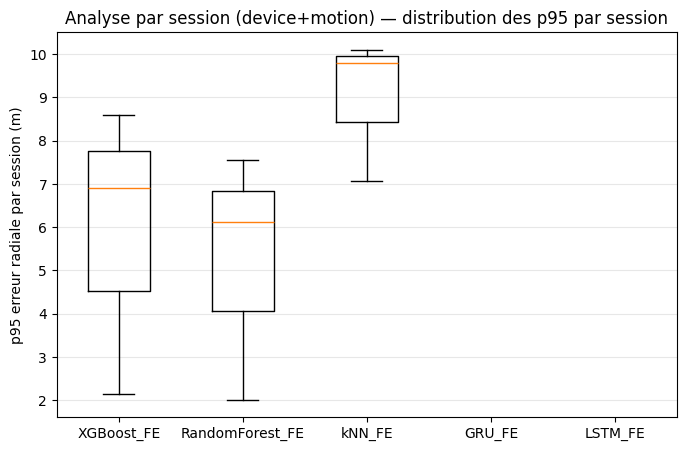


=== Pires sessions selon RandomForest_FE (top 5) ===
         session_id  device     motion    n  median_err_m  p90_err_m  p95_err_m  p99_err_m  max_err_m
  esp32__horizontal   esp32 horizontal  828      4.780004   7.298490   7.550193   8.128891   8.276222
    esp32__combined   esp32   combined 1389      0.618037   4.628438   6.123590   7.434938   8.363969
samsung__horizontal samsung horizontal  858      0.560582   1.620379   2.013270   2.888203   3.825170


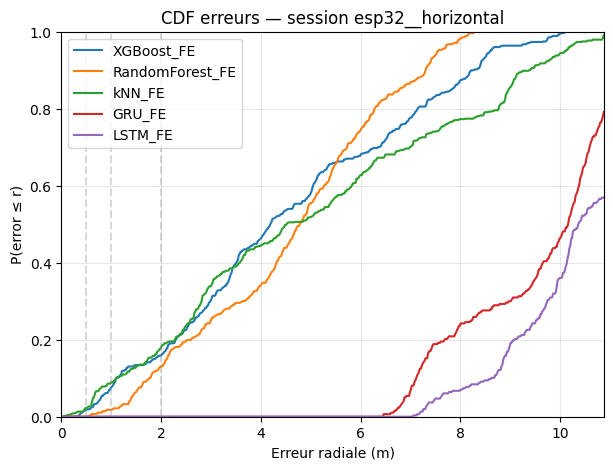

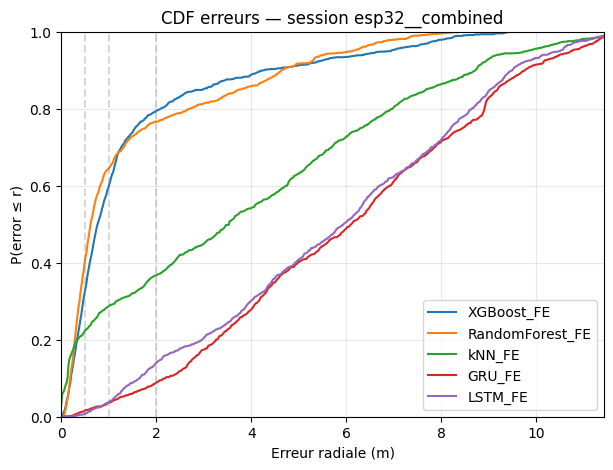

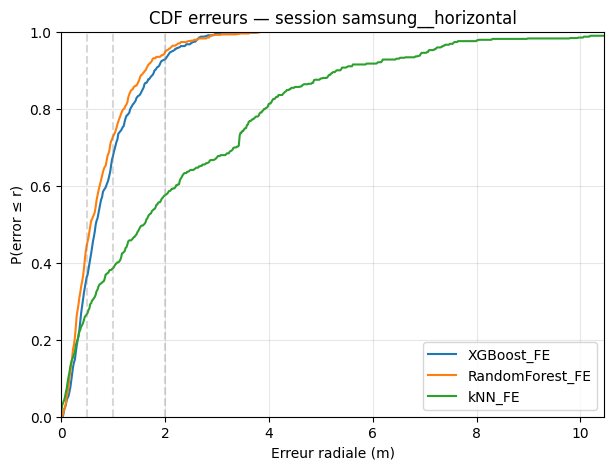

In [153]:
n_total = len(df_test_fe)

y_pred_lstm_fe_pointwise = seq_preds_to_pointwise(
    all_pred_LSTM_fe, idx_seq_test, n_total, agg="mean"
)

y_pred_gru_fe_pointwise = seq_preds_to_pointwise(
    all_pred_GRU_fe, idx_seq_test, n_total, agg="mean"
)


preds_by_model = {
  "XGBoost_FE": y_pred_xgb_fe,
  "RandomForest_FE": y_pred_rf_fe,
  "kNN_FE": y_pred_knn_fe,
  "GRU_FE": y_pred_gru_fe_pointwise,
  "LSTM_FE": y_pred_lstm_fe_pointwise,
}

session_long, p95_pivot = session_analysis_device_motion(
    df_test_base=df_test_fe,
    preds_by_model=preds_by_model,
    min_points_per_session=50,
    top_k_worst_sessions=5
)

Une analyse par session révèle que les performances globales masquent des disparités importantes selon le device et le type de mouvement.

La Random Forest présente la meilleure robustesse inter-session, avec une médiane de p95 inférieure aux autres modèles non séquentiels.

Les modèles séquentiels (GRU/LSTM) n’améliorent pas systématiquement la précision médiane, mais réduisent les erreurs extrêmes sur certaines trajectoires complexes.

Le mouvement horizontal apparaît comme le cas le plus difficile à localiser, indépendamment du modèle utilisé.

# Etape 4 : Analyse des résultats et discussion

             model     n  rmse_2d_m  mae_2d_m  median_err_m  \
0  RandomForest_FE  3075   3.103669  2.136132      1.007368   
1       XGBoost_FE  3075   3.248388  2.168762      1.050325   
2           GRU_FE  1648   4.342147  3.360593      2.328305   
3          LSTM_FE  1648   4.301088  3.463884      3.058553   
4           kNN_FE  3075   4.892040  3.761125      3.182598   

                                     errors_radial_m  p68_err_m  p90_err_m  \
0  [4.944290693546495, 4.948753395358985, 4.90109...   2.440927   5.848775   
1  [0.758974677979918, 1.1869711769304225, 1.1026...   2.169363   6.507211   
2  [2.6672546359147264, 2.5699135002684197, 2.345...   4.390786   7.720009   
3  [6.071681602956992, 5.954170564324821, 5.83054...   4.570705   7.182228   
4  [10.537248976844005, 7.318921798644396, 9.7079...   5.124522   8.765912   

   p95_err_m  p99_err_m  ...  rmse_x_m  rmse_y_m   mae_x_m   mae_y_m  \
0   6.821487   7.905887  ...  2.353846  2.022911  1.466884  1.240960   
1   7.87

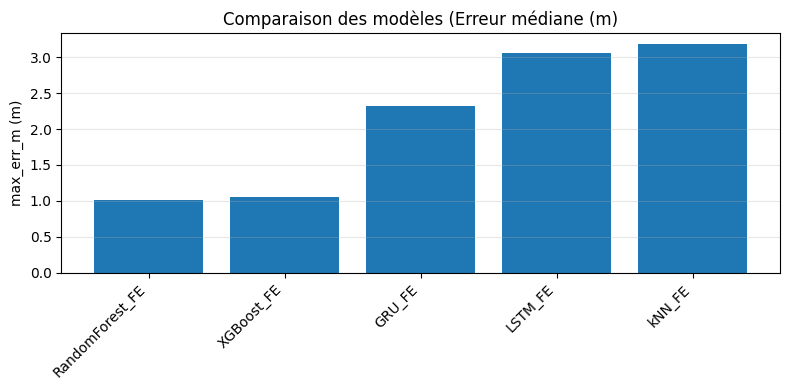

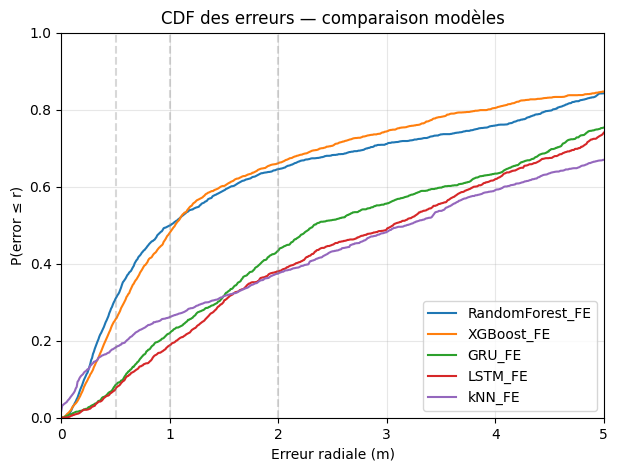

In [154]:
results_df = pd.DataFrame(results)

# Tri par p50 croissant
results_df = results_df.sort_values("median_err_m").reset_index(drop=True)

print(results_df)

plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["median_err_m"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("max_err_m (m)")
plt.title("Comparaison des modèles (Erreur médiane (m)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show(block=False)

plot_error_cdf(
    results_df,
    title="CDF des erreurs — comparaison modèles",
    max_m=5.0
)

In [155]:
def pick_session(df, device=None, motion=None):
    if device is None or motion is None:
        g = df.groupby(["device","motion"]).size().sort_values(ascending=False)
        device, motion = g.index[1]  # skip first as it is the largest
    return device, motion

def get_session_df(df_fe, X_fe_full, device, motion):
    mask = (df_fe["device"] == device) & (df_fe["motion"] == motion)
    df_s = df_fe.loc[mask].copy().reset_index(drop=True)
    X_s  = X_fe_full.loc[mask].copy().reset_index(drop=True)

    keep = df_s[["label_X","label_Y"]].notna().all(axis=1)
    df_s = df_s.loc[keep].reset_index(drop=True)
    X_s  = X_s.loc[keep].reset_index(drop=True)
    return df_s, X_s

def make_seq_from_session(df_s, feature_cols, window_size):
    Xv = df_s[feature_cols].to_numpy()
    yv = df_s[["label_X","label_Y"]].to_numpy()

    X_list, y_list, idx_list = [], [], []
    for i in range(len(df_s) - window_size + 1):
        X_list.append(Xv[i:i+window_size])
        y_list.append(yv[i+window_size-1])
        idx_list.append(i+window_size-1)
    return np.array(X_list), np.array(y_list), np.array(idx_list)

def predict_rf(rf_pipeline, X_df):
    pred = rf_pipeline.predict(X_df)
    pred = np.asarray(pred)
    assert pred.shape[1] == 2
    return pred

def predict_xgb_xy(xgb_x_pipeline, xgb_y_pipeline, X_s: pd.DataFrame) -> np.ndarray:
    pred_x = xgb_x_pipeline.predict(X_s)
    pred_y = xgb_y_pipeline.predict(X_s)
    return np.column_stack([pred_x, pred_y])

def predict_lstm_on_session(df_s, feature_cols, window_size, scaler_seq, model, device):
    X_seq, y_seq_true, idx = make_seq_from_session(df_s, feature_cols, window_size)

    N, T, D = X_seq.shape
    X_flat = X_seq.reshape(-1, D)
    X_flat_scaled = scaler_seq.transform(X_flat)
    X_scaled = X_flat_scaled.reshape(N, T, D)

    model.eval()
    with torch.no_grad():
        xb = torch.tensor(X_scaled, dtype=torch.float32, device=device)
        pred = model(xb).detach().cpu().numpy()

    return pred, y_seq_true, idx

def predict_gru_on_session(df_s, feature_cols, window_size, scaler_seq, model, device):
    X_seq, y_seq_true, idx = make_seq_from_session(df_s, feature_cols, window_size)

    N, T, D = X_seq.shape
    X_flat = X_seq.reshape(-1, D)
    X_flat_scaled = scaler_seq.transform(X_flat)
    X_scaled = X_flat_scaled.reshape(N, T, D)

    model.eval()
    with torch.no_grad():
        xb = torch.tensor(X_scaled, dtype=torch.float32, device=device)
        pred = model(xb).detach().cpu().numpy()

    return pred, y_seq_true, idx

In [156]:
# --- créer le dataframe et choisir une session ---
df_fe, X_fe_num, y, meta, feature_cols_num = feature_engineering_best(df_trimmed)

# ajoute device/motion pour les pipelines sklearn (cat)
X_fe = pd.concat([X_fe_num, df_fe[["device","motion"]]], axis=1)

# colonnes exactes attendues par le pipeline (= num + cat)
train_cols_pipeline = list(X_fe.columns)

# 1) sélectionner une session et créer le DF en conséquence
device_sel, motion_sel = pick_session(df_fe)
df_s, X_s = get_session_df(df_fe, X_fe, device_sel, motion_sel)

y_true = df_s[["label_X","label_Y"]].to_numpy()

# alignement robuste SANS perdre device/motion
X_s = X_s.reindex(columns=train_cols_pipeline, fill_value=0.0)

# --- prédiction kNN/RF/XGB (pipelines sklearn) ---
y_pred_knn_full = predict_rf(knn_pipeline_fe, X_s)
y_pred_rf_full = predict_rf(rf_pipeline_fe, X_s)
y_pred_xgb = predict_xgb_xy(xgb_x_pipeline_fe, xgb_y_pipeline_fe, X_s)

device_torch = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lstm_model = modelLSTM_fe.to(device_torch)
gru_model = modelGRU_fe.to(device_torch)

# 1) reconstruire la table d'entrée du LSTM comme au training
df_s_ohe = pd.concat([X_s.drop(columns=["device","motion"], errors="ignore"), df_s[["device","motion","label_X","label_Y"]]], axis=1)
df_s_ohe = pd.get_dummies(df_s_ohe, columns=["device","motion"], drop_first=True)


# 2) aligner EXACTEMENT les colonnes attendues (celles du training)
missing = set(feature_cols_lstm_gru) - set(df_s_ohe.columns)
extra   = set(df_s_ohe.columns) - set(feature_cols_lstm_gru) - {"label_X","label_Y"}

# créer les colonnes manquantes à 0 (cas: session sans samsung, etc.)
for c in missing:
    df_s_ohe[c] = 0.0

# enlever les colonnes en trop (sécurité)
df_s_ohe = df_s_ohe.drop(columns=list(extra), errors="ignore")

# re-ordonner strictement
df_s_ohe = df_s_ohe[feature_cols_lstm_gru + ["label_X","label_Y"]]

# 3) prédire lstm
y_pred_lstm, y_true_seq, idx_seq = predict_lstm_on_session(
    df_s_ohe,
    feature_cols=feature_cols_lstm_gru,
    window_size=WINDOW_SIZE,
    scaler_seq=scaler_lstm_gru,
    model=lstm_model,
    device=device_torch
)
# 4) prédire gru
y_pred_gru, y_true_seq, idx_seq = predict_gru_on_session(
    df_s_ohe,
    feature_cols=feature_cols_lstm_gru,
    window_size=WINDOW_SIZE,
    scaler_seq=scaler_lstm_gru,
    model=gru_model,
    device=device_torch
)

[FE] Generating rolling features (window=10) on 6 IMU cols...
[FE] New rolling features created: 24
[FE] IMU cols: 9 | deriv: 18 | roll: 24 (created=24)
[FE] Wi-Fi all: 11 | topK: 10 (K=10)
[FE] X_fe shape: (10156, 62) | NaN total: 0
{'imu_cols': ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnetoX', 'MagnetoY', 'MagnetoZ'], 'derivative_cols': ['AccelX_diff', 'AccelY_diff', 'AccelZ_diff', 'GyroX_diff', 'GyroY_diff', 'GyroZ_diff', 'MagnetoX_diff', 'MagnetoY_diff', 'MagnetoZ_diff', 'AccelX_dt', 'AccelY_dt', 'AccelZ_dt', 'GyroX_dt', 'GyroY_dt', 'GyroZ_dt', 'MagnetoX_dt', 'MagnetoY_dt', 'MagnetoZ_dt'], 'roll_cols': ['AccelX_roll_mean', 'AccelX_roll_var', 'AccelX_roll_min', 'AccelX_roll_max', 'AccelY_roll_mean', 'AccelY_roll_var', 'AccelY_roll_min', 'AccelY_roll_max', 'AccelZ_roll_mean', 'AccelZ_roll_var', 'AccelZ_roll_min', 'AccelZ_roll_max', 'GyroX_roll_mean', 'GyroX_roll_var', 'GyroX_roll_min', 'GyroX_roll_max', 'GyroY_roll_mean', 'GyroY_roll_var', 'GyroY_roll_min', 'GyroY

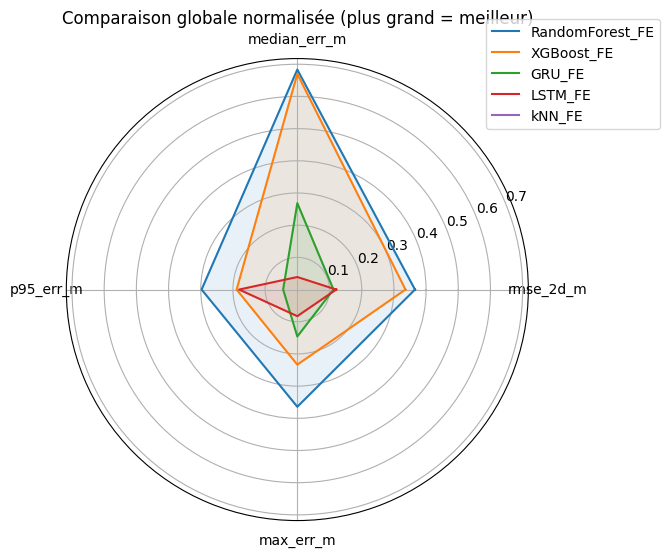

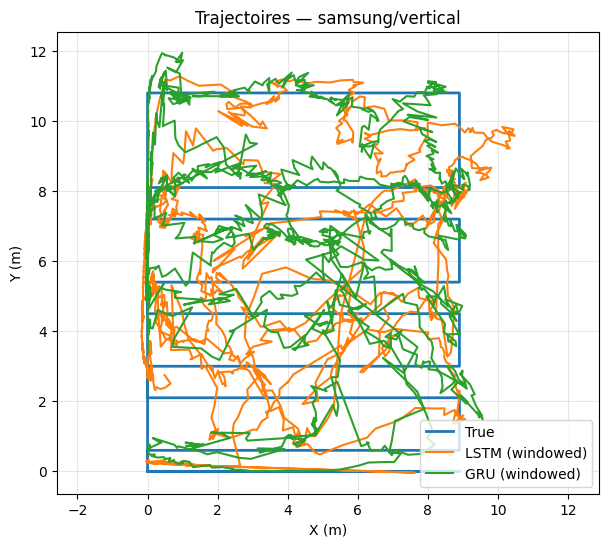

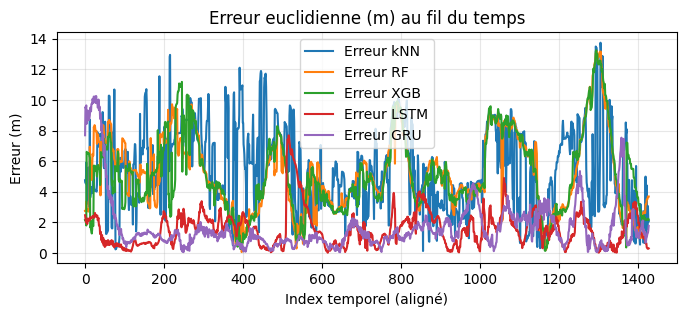

In [157]:
# alignement temporel across model
y_true_aligned = y_true[idx_seq]
y_pred_knn_aligned = y_pred_knn_fe[idx_seq]
y_pred_rf_aligned = y_pred_rf_fe[idx_seq]
y_pred_xgb_aligned = y_pred_xgb_fe[idx_seq]

# Performances sur la trajectoire
radar_metrics = [
    "rmse_2d_m",
    "median_err_m",
    "p95_err_m",
    "max_err_m",
]

df_radar = results_df[["model"] + radar_metrics].copy()

# normalisation inverse (plus petit = meilleur)
for c in radar_metrics:
    df_radar[c] = 1.0 - (df_radar[c] / df_radar[c].max())

angles = [n / float(len(radar_metrics)) * 2 * pi for n in range(len(radar_metrics))]
angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

for _, row in df_radar.iterrows():
    values = row[radar_metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row["model"])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics)
ax.set_title("Comparaison globale normalisée (plus grand = meilleur)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show(block=False)

# --- Trajectoires ---
plt.figure(figsize=(7,6))
plt.plot(y_true_aligned[:,0], y_true_aligned[:,1], label="True", linewidth=2)
# plt.plot(y_pred_xgb_aligned[:,0], y_pred_xgb_aligned[:,1], label="XGB (pointwise)") # Ne pas afficher
# plt.plot(y_pred_rf_aligned[:,0], y_pred_rf_aligned[:,1], label="RF (pointwise)") # Ne pas afficher
plt.plot(y_pred_lstm[:,0], y_pred_lstm[:,1], label="LSTM (windowed)")
plt.plot(y_pred_gru[:,0], y_pred_gru[:,1], label="GRU (windowed)")
plt.title(f"Trajectoires — {device_sel}/{motion_sel}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis("equal")
plt.grid(alpha=0.3)
plt.legend()
plt.show(block=False)

# --- Erreur euclidienne ---
err_knn = np.linalg.norm(y_true_aligned - y_pred_knn_aligned, axis=1)
err_rf = np.linalg.norm(y_true_aligned - y_pred_rf_aligned, axis=1)
err_xgb = np.linalg.norm(y_true_aligned - y_pred_xgb_aligned, axis=1)
err_lstm = np.linalg.norm(y_true_aligned - y_pred_lstm, axis=1)
err_gru = np.linalg.norm(y_true_aligned - y_pred_gru, axis=1)

plt.figure(figsize=(8,3))
plt.plot(err_knn, label="Erreur kNN")
plt.plot(err_rf, label="Erreur RF")
plt.plot(err_xgb, label="Erreur XGB")
plt.plot(err_lstm, label="Erreur LSTM")
plt.plot(err_gru, label="Erreur GRU")
plt.title("Erreur euclidienne (m) au fil du temps")
plt.xlabel("Index temporel (aligné)")
plt.ylabel("Erreur (m)")
plt.grid(alpha=0.3)
plt.legend()
plt.show(block=False)

On voit que les prédicteur pointwise sont globalement plus mauvais pour déterminer les positions dans une séquence de mouvement que les prédicteurs séquentiels. Mais existe-t-il une solution hybride pour pallier aux deux problèmes ?

In [158]:
def hybrid_fusion(y_xgb, y_lstm, alpha=0.7):
    """
    y_xgb, y_lstm: (N,2)
    alpha: poids XGB (0..1)
    """
    assert y_xgb.shape == y_lstm.shape
    return alpha * y_xgb + (1 - alpha) * y_lstm

alpha = 0.5
y_pred_hybrid = hybrid_fusion(y_pred_xgb_aligned, y_pred_lstm, alpha=alpha)

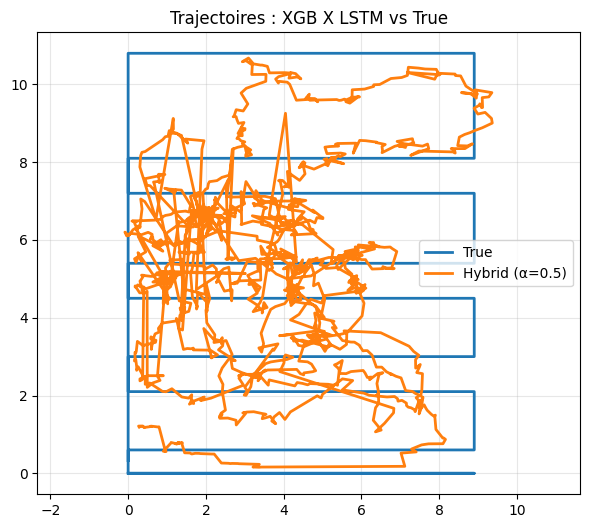

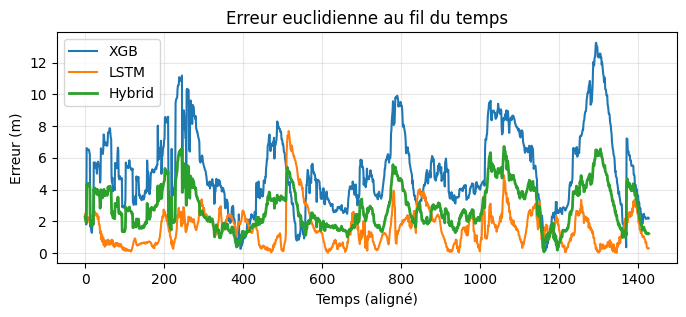

RMSE XGB    : 5.747439432500331
RMSE LSTM   : 1.9801019044909207
RMSE Hybrid : 3.1847203287920816


In [159]:
plt.figure(figsize=(7,6))
plt.plot(y_true_aligned[:,0], y_true_aligned[:,1], label="True", linewidth=2)
# plt.plot(y_pred_xgb_aligned[:,0], y_pred_xgb_aligned[:,1], label="XGB", alpha=0.6)
# plt.plot(y_pred_lstm[:,0], y_pred_lstm[:,1], label="LSTM", alpha=0.6)
plt.plot(y_pred_hybrid[:,0], y_pred_hybrid[:,1], label=f"Hybrid (α={alpha})", linewidth=2)
plt.axis("equal")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Trajectoires : XGB X LSTM vs True")
plt.show(block=False)

err_hybrid = np.linalg.norm(y_true_aligned - y_pred_hybrid, axis=1)

plt.figure(figsize=(8,3))
plt.plot(err_xgb, label="XGB")
plt.plot(err_lstm, label="LSTM")
plt.plot(err_hybrid, label="Hybrid", linewidth=2)
plt.ylabel("Erreur (m)")
plt.xlabel("Temps (aligné)")
plt.title("Erreur euclidienne au fil du temps")
plt.grid(alpha=0.3)
plt.legend()
plt.show(block=False)

print("RMSE XGB    :", np.sqrt(np.mean(err_xgb**2)))
print("RMSE LSTM   :", np.sqrt(np.mean(err_lstm**2)))
print("RMSE Hybrid :", np.sqrt(np.mean(err_hybrid**2)))


## Conclusion sur les différents modèles

Les résultats obtenus au cours de cette étude mettent en évidence la complexité intrinsèque du problème de localisation indoor à partir de données hétérogènes issues de capteurs inertiels et de signaux Wi-Fi. Les évaluations réalisées à l’aide de métriques adaptées au contexte applicatif (erreur radiale, percentiles p90/p95, CDF des erreurs et analyse par session) montrent que les performances globales peuvent masquer des comportements très contrastés selon les trajectoires, les dispositifs et les types de mouvement.

Les modèles non séquentiels, en particulier la Random Forest, offrent une excellente performance globale et une bonne robustesse inter-session. Ils constituent ainsi des baselines solides pour ce type de problématique. XGBoost atteint des performances comparables en termes de précision médiane, mais se révèle plus sensible aux cas difficiles, ce qui se traduit par des erreurs extrêmes plus élevées sur certaines sessions.

Les modèles séquentiels (LSTM et GRU) n’améliorent pas systématiquement la précision instantanée, mais apportent un gain notable en termes de stabilité et de réduction des erreurs extrêmes sur des trajectoires complexes. Le GRU apparaît comme le compromis le plus intéressant parmi les modèles séquentiels testés, combinant une architecture plus simple et une meilleure robustesse dans ce cadre expérimental.

L’analyse par session a par ailleurs montré que les performances dépendent fortement du contexte, notamment du type de mouvement et du dispositif utilisé. Certaines sessions concentrent l’essentiel des erreurs élevées, ce qui souligne l’importance d’une évaluation contextuelle et multi-niveaux pour juger de la pertinence réelle d’un modèle de localisation indoor.


## Discussion

### 1. Analyse globale des performances

Les résultats obtenus montrent que la localisation indoor à partir de signaux hétérogènes (IMU et Wi-Fi) constitue un problème fortement non linéaire et dépendant du contexte expérimental. Les modèles linéaires utilisés en baseline se révèlent insuffisants pour capturer la complexité des relations entre les observations capteurs et la position 2D, ce qui confirme la nécessité de recourir à des méthodes d’apprentissage plus expressives.

Parmi les modèles non séquentiels évalués, la Random Forest se distingue par une meilleure robustesse globale, en particulier sur les métriques liées aux erreurs extrêmes (p90, p95). À l’inverse, XGBoost présente une précision médiane comparable, mais une plus grande variabilité dans les cas difficiles, traduisant une sensibilité accrue aux configurations ambiguës du signal. Ces résultats suggèrent que la capacité d’agrégation de décisions de la Random Forest permet une meilleure généralisation inter-session dans ce contexte.

Le modèle de type k-nearest neighbors, utilisé comme baseline spécifique au domaine de la localisation indoor (fingerprinting), obtient de bonnes performances sur les faibles distances, mais s’effondre rapidement lorsque l’erreur augmente. Ce comportement est cohérent avec la littérature, le kNN étant particulièrement sensible au bruit RSSI, à la variabilité temporelle du signal et aux changements de contexte environnemental.

---

### 2. Apport des modèles séquentiels

Les modèles séquentiels (LSTM et GRU) n’améliorent pas systématiquement la précision médiane par rapport aux modèles non séquentiels. En revanche, ils montrent un intérêt notable dans la réduction des erreurs extrêmes sur certaines trajectoires complexes, comme le met en évidence l’analyse des queues de distribution (CDF) et des métriques p95.

Ce comportement s’explique par la capacité des réseaux récurrents à exploiter la continuité temporelle de la trajectoire, ce qui permet d’amortir les fluctuations ponctuelles du signal Wi-Fi et des capteurs inertiels. Le GRU, en particulier, présente une meilleure stabilité que le LSTM dans ce cadre expérimental, ce qui peut être attribué à une architecture plus simple et moins sujette au sur-apprentissage compte tenu de la taille du jeu de données.

Ces observations suggèrent que les modèles séquentiels sont davantage pertinents dans une optique de robustesse et de fiabilité, plutôt que pour l’optimisation de la précision instantanée.

---

### 3. Analyse par session et dépendance au contexte

L’analyse par session (définie ici par le couple *device*–*motion*) met en évidence de fortes disparités de performance selon le type de mouvement et le matériel utilisé. Certaines sessions, en particulier celles associées à des mouvements horizontaux, présentent des erreurs significativement plus élevées quel que soit le modèle considéré.

Ce résultat indique que les difficultés de localisation sont en grande partie liées à la nature du signal lui-même, et non uniquement au choix de l’algorithme. La dépendance aux conditions de mouvement et au dispositif utilisé souligne l’importance de considérer des métriques par session, les métriques globales pouvant masquer des comportements problématiques localisés.

Il est également important de noter que l’analyse par session pour les modèles séquentiels est réalisée sur un sous-ensemble des données, correspondant aux points pour lesquels une prédiction valide peut être produite après fenêtrage temporel. Certaines sessions sont ainsi exclues faute de points exploitables, ce qui constitue une limite méthodologique assumée et explicitée.

---

### 4. Limites de l’approche

Plusieurs limites doivent être soulignées. Tout d’abord, la définition des sessions comme couples (*device*, *motion*) conduit à une agrégation de plusieurs trajectoires expérimentales distinctes, ce qui peut masquer des variations intra-session. Une définition plus fine des sessions, basée sur des identifiants de trajectoires ou de fichiers d’acquisition, permettrait une analyse plus granulaire.

Par ailleurs, le feature engineering, bien que riche, repose sur des statistiques locales (fenêtres glissantes, dérivées temporelles) et une sélection heuristique des points d’accès Wi-Fi. Une approche plus formelle de type *fit/transform* ou l’intégration de modèles probabilistes de propagation pourrait améliorer la rigueur du pipeline.

Enfin, l’approche proposée ne tient pas compte de contraintes topologiques ou cartographiques (murs, couloirs), ni de mécanismes de recalage inertiel ou de fusion probabiliste (par exemple via filtres de Kalman ou méthodes de SLAM). Ces éléments constituent des pistes d’amélioration naturelles pour une application en conditions réelles.

---

### 5. Perspectives

Les résultats obtenus montrent qu’une combinaison de modèles non séquentiels robustes et de modèles séquentiels orientés vers la stabilité constitue une approche prometteuse pour la localisation indoor. Des travaux futurs pourraient explorer des architectures hybrides, combinant prédictions instantanées et lissage temporel, ou intégrer des informations structurelles sur l’environnement.

Dans l’ensemble, cette étude met en évidence l’importance d’une évaluation rigoureuse, multi-critères et contextuelle, pour juger de la pertinence des modèles de localisation indoor, au-delà des seules métriques globales moyennes.


# Conclusion générale

Ce travail a permis d’explorer de manière approfondie la problématique de la localisation indoor à partir de données hétérogènes issues de capteurs inertiels et de signaux Wi-Fi, dans un contexte réaliste marqué par une forte variabilité du signal et une dépendance importante aux conditions d’acquisition. L’objectif n’était pas uniquement d’obtenir les meilleures performances possibles, mais surtout de comprendre les limites et les comportements des différentes approches de modélisation dans un cadre expérimental contrôlé et reproductible.

L’étude a mis en évidence que la localisation indoor ne peut être correctement abordée à l’aide de modèles simples ou purement linéaires. La complexité des interactions entre le mouvement, la géométrie de l’environnement, le matériel utilisé et la dynamique du signal Wi-Fi impose le recours à des modèles capables de capturer des relations non linéaires et, dans certains cas, des dépendances temporelles. Les modèles non séquentiels, en particulier la Random Forest, se sont révélés très efficaces pour exploiter des représentations enrichies des données, offrant un excellent compromis entre performance, robustesse et simplicité de mise en œuvre. Ils constituent ainsi des candidats sérieux pour une première implémentation opérationnelle.

Les modèles séquentiels, quant à eux, apportent un éclairage complémentaire sur la nature temporelle du problème. Bien qu’ils n’améliorent pas systématiquement la précision instantanée, ils contribuent à stabiliser les prédictions et à limiter les erreurs extrêmes sur certaines trajectoires complexes. Cette observation est particulièrement importante dans une perspective applicative, où la fiabilité et la cohérence des estimations peuvent être plus critiques que la minimisation de l’erreur moyenne. Les résultats obtenus suggèrent que l’exploitation de la temporalité doit être pensée non pas comme un substitut aux modèles classiques, mais comme un mécanisme de régularisation et de robustification.

Une amélioration significative nécessiterait soit une carte explicite de l’environnement, soit une fusion capteurs plus avancée (PDR, map-matching), ce qui dépasse le cadre de ce projet de M2.

Un apport majeur de ce projet réside également dans l’attention portée à l’évaluation. L’utilisation de métriques adaptées au contexte de la localisation indoor, combinée à une analyse par session, a permis de dépasser une lecture purement globale des performances. Cette approche a mis en évidence des disparités importantes selon le type de mouvement et le dispositif utilisé, révélant que certaines configurations sont intrinsèquement plus difficiles à localiser. Ces résultats soulignent l’importance d’une évaluation contextualisée, sans laquelle les performances moyennes peuvent conduire à des conclusions trompeuses.

Enfin, ce travail met en lumière plusieurs axes d’amélioration et d’extension. L’intégration de contraintes physiques ou topologiques sur l’environnement, l’utilisation de méthodes probabilistes de fusion de capteurs, ou encore le développement d’architectures hybrides combinant prédictions instantanées et modèles temporels constituent des pistes naturelles pour améliorer la robustesse et la généralisation des systèmes de localisation indoor. De plus, une définition plus fine des sessions expérimentales et une collecte de données plus diversifiée permettraient d’affiner l’analyse et de renforcer la validité des conclusions.

En définitive, ce projet démontre qu’une approche méthodique, associant traitement avancé des données, choix raisonné des modèles et évaluation rigoureuse, est essentielle pour aborder efficacement la localisation indoor. Les résultats obtenus ne constituent pas une solution définitive, mais une base solide et cohérente pour des travaux futurs visant à concevoir des systèmes de positionnement intérieur plus fiables, plus robustes et mieux adaptés aux contraintes du monde réel.
